# ❓ Questions to Reflect On


#### What do you observe when comparing the model’s predictions on the new data to its known performance?

**Performance Degradation**: The model shows a clear performance drop on inference data:
+ Train accuracy: 100%, recall: 100% (expected high performance, and more importantly high Recall (Sensitivity) for minimum Type II error)
+ Test (validation) accuracy: 94.5%, recall: 94.5% (normal validation performance)  
+ Inference accuracy: 64.4% (significant drop)

        *(section 2 - model performance evaluation)*



#### Is there anything in the data that might explain differences in behavior?

**Yes, there is significant feature drift**
approximately  60% of the unseen inference dataset signals being out-of-distribution (OOD) I have also examined and ruled out label distribution imbalance. Additionally, the data appears noisier (some preprocessing steps might have been missing).

    *(sections 3-4 - features distribution and drift analysis)* 


#### Can you identify patterns or trends related to when the model succeeds or fails?

**in-distribution vs. OOD**
The model achieves 90.7% accuracy on in-distribution samples in the inference dataset, but only 47.9% accuracy for OOD samples, which is no better than random. All OOD samples are classified as 'collision,' possibly due inherent model bias or to an internal model policy combined with OOD detector.

#### Are there signals or features that seem to affect the model’s reliability?

+ Signals – as mentioned above fewer then 50% are signals that the model learned hence reducing model’s reliability.
+ Features – there are some features who are relatively stable and also highly influencial in the model, e.g. y_max. However, many other features have drifted significantly (e.g., y_energy, x_min, x_energy), negatively affecting model reliability to cope with unseen data.
+ (worth noting that all features are derived from three primary signals, with higher-order (momentum-related) features appearing less impacted by drift.)

#### What could be done in the short term to handle the current situation?

**Divide and conquer:**
1. Continuously measure drift and perform inference only on in-distribution samples.
2. try checking:
    + calibration techniques 
    + data scaling         
        
         
             *(appendix - A2)*

3. If inference on OOD samples is absolutly a must, try heuristic approaches on OOD such as:
+ Policy-dependent heuristic: Currently, all OOD samples are classified as 'collision.' Assuming ground truth labels remain approximately balanced, randomly adjusting some predictions from 'collision' to 'normal' would lead to a mix of true negatives and false negatives. This strategy may slightly reduce recall but improve precision and accuracy overall. (and maybe F1 as well)
+ Further explore indicators such as confidence levels or drift distance/direction, decision boundaries. Trimming or masking out some features 
                
         *(see expereiments in Section A in the appendix).*


#### What are potential long-term steps to improve model performance in similar scenarios?

+ The model is currently overfitted to the training data; further training on more diverse samples is necessary. 
+ Data augmentation ( temperature scaling, phase shifts, signal noise addition..)
+ Using differnet model that doesn't assumes stationarity of the data distribution


#### What would you want to explore further if given more time or data?


+ Experiment further with signal processing techniques for denoising and sensor calibration.

+ Develop a mechanism to reweight features based on their driftXimportance.

+ Combining techniques - such as scaling new data, incorporating confidence and drift distance as additional features, and implementing noise filters.


#### What assumptions did the model rely on during training — and are they still valid?

The primary assumption was that the training data is representative of real-world distributions \ (or if accusing the model: it implicitly assumes stationarity of the data distribution) which is violated here.

        
            
    
  *code was written with 'claude code' kind assitanat*

# 1. Setup and Data Loading

Import required libraries, load datasets, and configure the analysis environment.

In [1]:
from extract_features import process_dataset, load_and_process_sample
from visualization import signal_viewer
from imu_pipeline import IMUPipeline
from pathlib import Path
import pandas as pd
import joblib
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, roc_curve, auc, confusion_matrix, classification_report,
    precision_recall_curve
)
from scipy import stats
from scipy.stats import ks_2samp
import warnings
warnings.filterwarnings('ignore')
import glob

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
# Fix matplotlib plotting issues
plt.ion()  # Turn on interactive mode
%matplotlib inline


In [2]:
signal_viewer(
    data_dir=Path('data/raw/train'),
    labels_csv=Path('data/train.csv')
)

signal_viewer(
    data_dir=Path('data/raw/inference'),
    labels_csv=Path('data/manual_annotation/inference_labels.csv')
)

In [3]:
pd.set_option('display.max_columns', None)

from extract_features import process_dataset
process_dataset('inference')



[INFO] No label CSV found for 'inference' – proceeding without labels.

Processing 'inference' dataset...


  0%|          | 0/473 [00:00<?, ?it/s]

100%|██████████| 473/473 [00:08<00:00, 56.16it/s]


Processed 473 samples to data/inference.csv


,x_mean,x_std,x_max,x_min,x_range,x_skew,x_kurtosis,x_n_peaks,x_energy,y_mean,y_std,y_max,y_min,y_range,y_skew,y_kurtosis,y_n_peaks,y_energy,z_mean,z_std,z_max,z_min,z_range,z_skew,z_kurtosis,z_n_peaks,z_energy,mag_mean,mag_std,mag_max,max_delta_mag,sudden_change_score,x_fft_max,x_fft_mean,y_fft_max,y_fft_mean,z_fft_max,z_fft_mean,xy_corr,xz_corr,yz_corr,sample_id,sensor_source,timestamp,weather,driver_id,vehicle_type,speed_bin,road_type,time_of_day,temperature,humidity,altitude,session_id,firmware_version,calibration_status,battery_level,gps_accuracy,network_type,device_model
0,0.058921,0.141937,0.263645,-0.227241,0.490886,-0.411727,-1.269705,17,2.361775,0.016296,0.153913,0.347024,-0.303284,0.650308,-0.019326,-0.282701,5,2.395465,9.840018,0.042225,9.939898,9.730363,0.209534,-0.228049,-0.260705,32,9682.774111,9.842435,0.042258,9.943422,0.098492,3,8.674506,0.664033,9.322225,0.722368,984.001820,19.995811,0.172658,0.229105,-0.384627,0143cf13-fd51-44fd-8dd4-c2c92f5db7bd,camera,2025-05-25 14:34:56.480223,rain,D1072,sedan,fast,highway,night,29,21,383,S910846,v1.2.4,pending,97,5.613430,5g,model_b
1,0.106114,0.269372,1.778952,-0.216834,1.995787,3.211183,15.644389,1,8.382128,0.056256,0.223806,1.242307,-0.294214,1.536521,1.961874,7.529911,3,5.325368,9.843725,0.044668,9.965225,9.746288,0.218937,0.022311,-0.393271,32,9690.091581,9.850638,0.054110,10.108895,0.281734,3,12.935397,2.177880,9.734227,1.688765,984.372494,20.015302,0.685087,0.213216,-0.250037,01b5f718-2978-468f-9789-89003ba755e6,camera,2025-05-25 14:34:55.857350,fog,D1005,sedan,slow,rural,night,15,58,163,S745147,v1.3.0,pending,60,1.196678,5g,model_b
2,0.789526,2.145882,9.063698,-5.985732,15.049430,0.780326,3.492323,11,522.816335,0.819377,1.552300,8.455555,-3.559972,12.015527,1.029458,5.506524,12,308.101441,9.909722,0.860098,12.189286,7.668287,4.520999,0.302893,0.119913,29,9894.235414,10.297209,1.104095,14.907621,4.759454,7,78.952640,20.173811,81.937697,15.842274,990.972176,26.881383,0.202195,0.160524,-0.142887,01fb46f8-2dc1-4bd3-a823-252a87c3bd03,phone,2025-05-25 14:34:56.305350,rain,D1095,truck,slow,highway,night,32,55,838,S815741,v1.3.0,ok,39,3.882185,wifi,model_b
3,0.608177,1.767987,7.425284,-5.526085,12.951369,0.051386,2.937480,15,349.565584,1.388228,1.273797,4.650763,-3.475920,8.126683,0.141400,1.819057,29,354.973666,9.335669,0.757647,11.397168,7.780933,3.616235,0.342385,0.427156,32,8772.873686,9.694133,0.893262,12.409911,3.373015,5,60.817723,16.529566,138.822786,13.926728,933.566855,25.271885,0.109542,-0.151401,0.106341,022ae887-3b50-4440-94af-446a1cec3f87,phone,2025-05-25 14:34:56.531446,clear,D1080,sedan,fast,urban,afternoon,24,71,166,S192238,v1.2.3,ok,46,3.886005,wifi,model_b
4,-1.194933,1.703552,5.421388,-5.423952,10.845341,1.637340,4.764184,5,432.995344,-0.195628,1.496473,4.983950,-7.211390,12.195340,-0.928716,6.568596,3,227.770190,11.350450,0.897118,14.141260,9.188245,4.953016,0.440627,0.748016,31,12963.754174,11.625941,1.040521,16.069924,5.474084,5,119.493275,17.381092,29.533332,13.802207,1135.045029,30.538899,-0.208418,-0.231917,-0.217719,02d8b8af-803d-4898-9eb5-51b771e5f2d9,phone,2025-05-25 14:34:56.261825,fog,D1015,truck,medium,rural,night,27,52,720,S146695,v1.2.3,recent,36,7.753421,4g,model_a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,-1.636018,1.836926,6.591974,-9.584012,16.175985,0.312256,7.618219,3,605.085057,1.075774,1.695301,6.482397,-7.164478,13.646875,-0.540911,6.073187,15,403.133334,9.793264,0.854602,12.054821,7.994420,4.060400,0.462240,-0.044284,37,9663.835516,10.261484,1.192682,14.557905,4.560913,6,163.601801,18.872970,107.577391,17.020440,979.326355,27.143569,-0.026207,0.040792,-0.016970,fd5548de-22c7-4a7a-9a60-a72a111cfb0d,phone,2025-05-25 14:34:55.866962,clear,D1039,truck,slow,highway,afternoon,24,75,720,S259109,v1.2.3,ok,76,3.351859,5g,model_b
469,

In [4]:
labels = pd.read_csv("data/manual_annotation/inference_labels.csv")
df_inf = pd.read_csv("data/inference.csv")
model = joblib.load("models/imu_pipeline.pkl")

preds = model.predict(df_inf)
probs = model.predict_proba(df_inf)

# Load all datasets
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
inference_df = pd.read_csv('data/inference.csv')
inference_labels = pd.read_csv('data/manual_annotation/inference_labels.csv')

# Merge inference with labels
inference_merged = inference_df.merge(inference_labels, on='sample_id', how='inner')

# Load model
model = joblib.load('models/imu_pipeline.pkl')

# Get feature columns from the model
from imu_pipeline import signal_features

print(f"   Train: {len(train_df)} samples")
print(f"   Test: {len(test_df)} samples")
print(f"   Inference: {len(inference_merged)} samples")
print(f"   Features: {len(signal_features)} features")
print(f"   Model: {type(model).__name__}")
print(model.model)







   Train: 800 samples
   Test: 200 samples
   Inference: 473 samples
   Features: 41 features
   Model: IMUPipeline
RandomForestClassifier(random_state=42)


In [5]:
 # Function to evaluate model on dataset
def evaluate_dataset(dataset, dataset_name, model):
    """Evaluate model performance on a given dataset"""
    
    # Prepare data
    X = dataset
    y_true = dataset['label']
    
    # Generate predictions
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    # Get collision probabilities
    collision_idx = np.where(model.label_encoder.classes_ == 'collision')[0][0]
    y_probs_collision = y_pred_proba[:, collision_idx]
    
    # Convert labels to binary for ROC calculation
    y_true_binary = (y_true == 'collision').astype(int)
    
    # Calculate metrics
    metrics = {
        'dataset': dataset_name,
        'n_samples': len(y_true),
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='weighted'),
        'recall': recall_score(y_true, y_pred, average='weighted'),
        'f1_score': f1_score(y_true, y_pred, average='weighted'),
        'precision_macro': precision_score(y_true, y_pred, average='macro'),
        'recall_macro': recall_score(y_true, y_pred, average='macro'),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'roc_auc': roc_auc_score(y_true_binary, y_probs_collision),
        'y_true': y_true,
        'y_pred': y_pred,
        'y_probs': y_probs_collision
    }
    
    # Label distribution
    label_dist = y_true.value_counts(normalize=True)
    metrics['collision_rate'] = label_dist.get('collision', 0)
    metrics['normal_rate'] = label_dist.get('normal', 0)
    
    return metrics

# 2. Model Performance Evaluation

Evaluate model performance across train, test, and inference datasets.

CROSS-DATASET PERFORMANCE COMPARISON
  Dataset  N Samples Accuracy Precision Recall F1-Score ROC AUC Collision Rate Normal Rate
    Train        800   1.0000    1.0000 1.0000   1.0000  1.0000          0.500       0.500
     Test        200   0.9450    0.9505 0.9450   0.9448  0.9281          0.500       0.500
Inference        473   0.6448    0.7384 0.6448   0.6066  0.7611          0.499       0.501


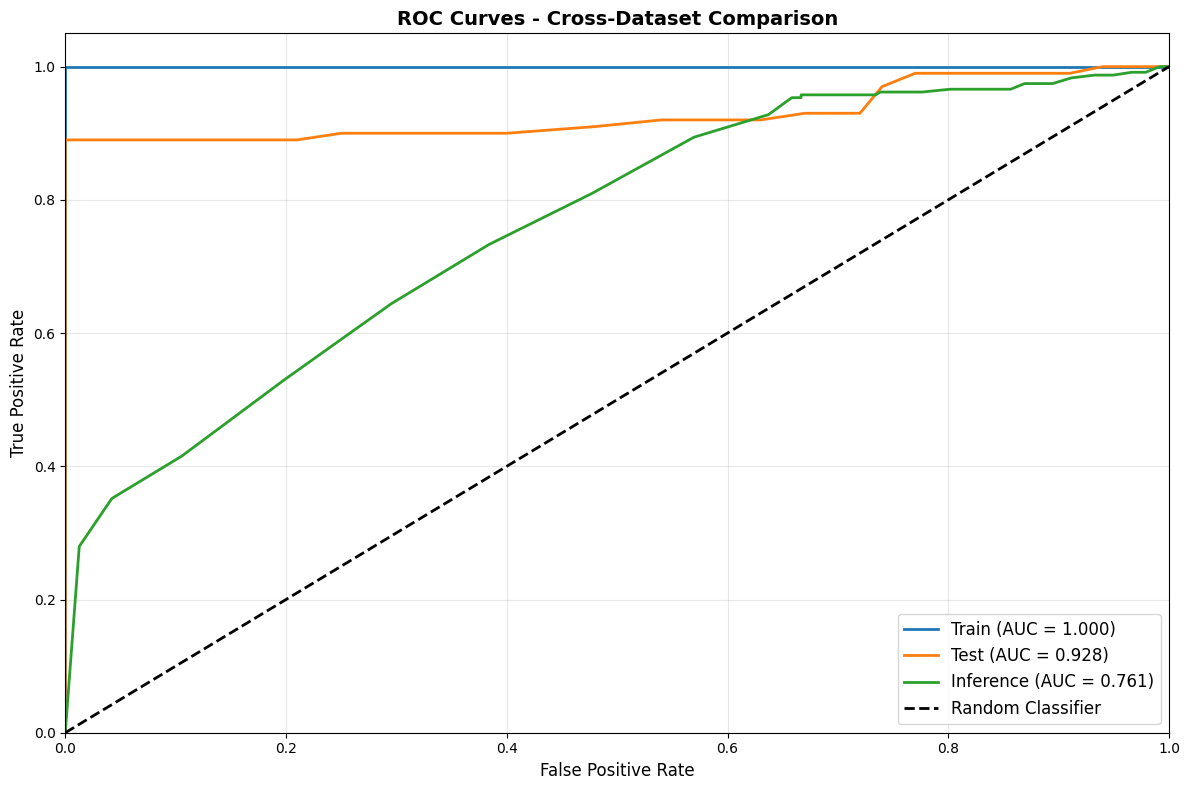

In [6]:
results = {
    'train': evaluate_dataset(train_df, 'Train', model),
    'test': evaluate_dataset(test_df, 'Test', model),
    'inference': evaluate_dataset(inference_merged, 'Inference', model)
}

# Create performance comparison table
performance_metrics = []
for dataset_name, result in results.items():
    performance_metrics.append({
        'Dataset': dataset_name.capitalize(),
        'N Samples': result['n_samples'],
        'Accuracy': f"{result['accuracy']:.4f}",
        'Precision': f"{result['precision']:.4f}",
        'Recall': f"{result['recall']:.4f}",
        'F1-Score': f"{result['f1_score']:.4f}",
        'ROC AUC': f"{result['roc_auc']:.4f}",
        'Collision Rate': f"{result['collision_rate']:.3f}",
        'Normal Rate': f"{result['normal_rate']:.3f}"
    })

performance_df = pd.DataFrame(performance_metrics)
print("CROSS-DATASET PERFORMANCE COMPARISON")
print("="*80)
print(performance_df.to_string(index=False))

# ROC Curve Comparison
plt.figure(figsize=(12, 8))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
dataset_names = ['Train', 'Test', 'Inference']

for i, (dataset_key, dataset_name) in enumerate(zip(results.keys(), dataset_names)):
    y_true = results[dataset_key]['y_true']
    y_probs = results[dataset_key]['y_probs']
    
    y_true_binary = (y_true == 'collision').astype(int)
    fpr, tpr, _ = roc_curve(y_true_binary, y_probs)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color=colors[i], lw=2, 
             label=f'{dataset_name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Cross-Dataset Comparison', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 2.1 Cross-Dataset Performance Comparison

# 3. Feature Distribution Analysis

Analyze feature distributions across datasets to detect data drift.

In [7]:
# Extract feature data for each dataset
feature_data = {
    'train': train_df[signal_features].copy(),
    'test': test_df[signal_features].copy(), 
    'inference': inference_merged[signal_features].copy()
}

# Select key features for detailed analysis
key_features = ['x_mean', 'y_mean', 'z_mean', 'mag_mean', 'x_std', 'y_std', 'z_std', 'mag_std']

print("FEATURE DISTRIBUTION ANALYSIS")
print("="*50)
print(f"Analyzing {len(signal_features)} features across datasets")
print(f"Key features: {', '.join(key_features)}")

# Calculate basic statistics for each dataset
stats_summary = []
for dataset_name, data in feature_data.items():
    stats = {
        'Dataset': dataset_name.capitalize(),
        'Mean': data.mean().mean(),
        'Std': data.std().mean(),
        'Min': data.min().min(),
        'Max': data.max().max(),
        'Skewness': data.skew().mean(),
        'Kurtosis': data.kurtosis().mean()
    }
    stats_summary.append(stats)

stats_df = pd.DataFrame(stats_summary)
print("\nFeature Statistics Summary:")
print(stats_df.round(4))

FEATURE DISTRIBUTION ANALYSIS
Analyzing 41 features across datasets
Key features: x_mean, y_mean, z_mean, mag_mean, x_std, y_std, z_std, mag_std

Feature Statistics Summary:
     Dataset      Mean      Std      Min         Max  Skewness  Kurtosis
0      Train  264.1147   1.4804  -5.5799   9712.9804    0.7514    1.6438
1       Test  264.1293   1.5654  -5.3087   9707.3401    0.7105    1.3761
2  Inference  300.5545  76.5163 -15.2424  20357.7031    0.2415    0.4390


## 3.1 Feature Statistics and Visualization

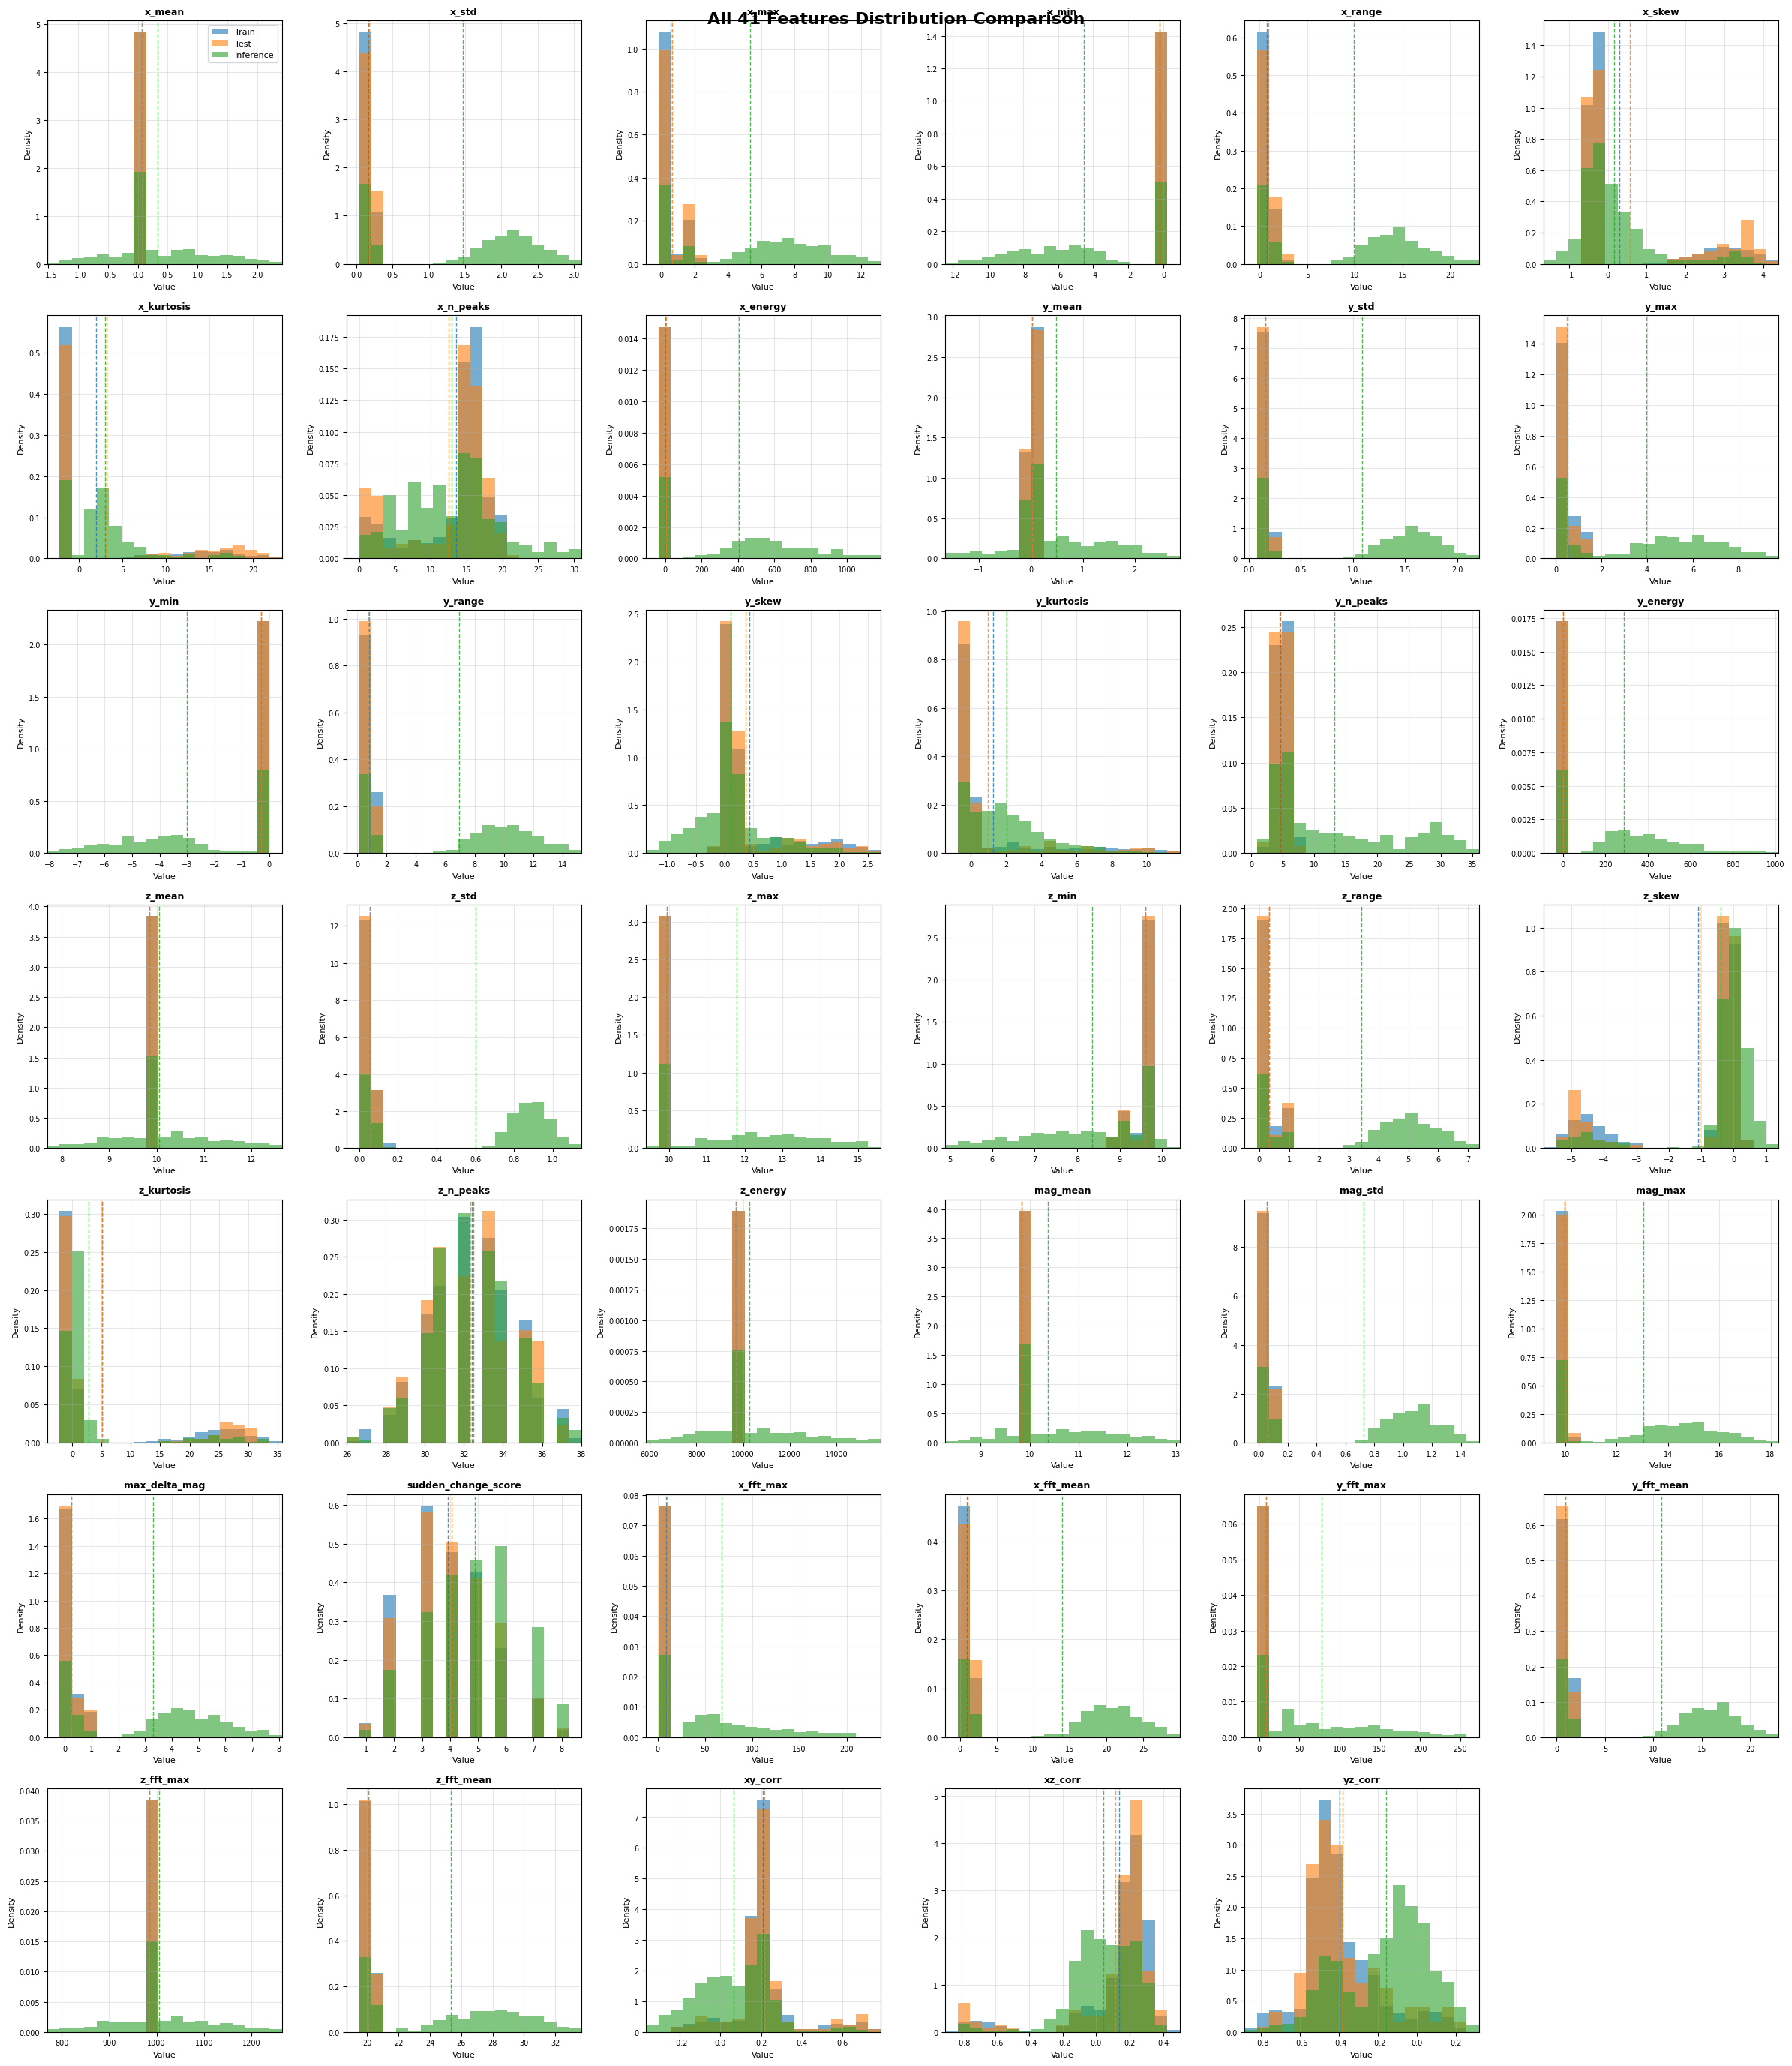

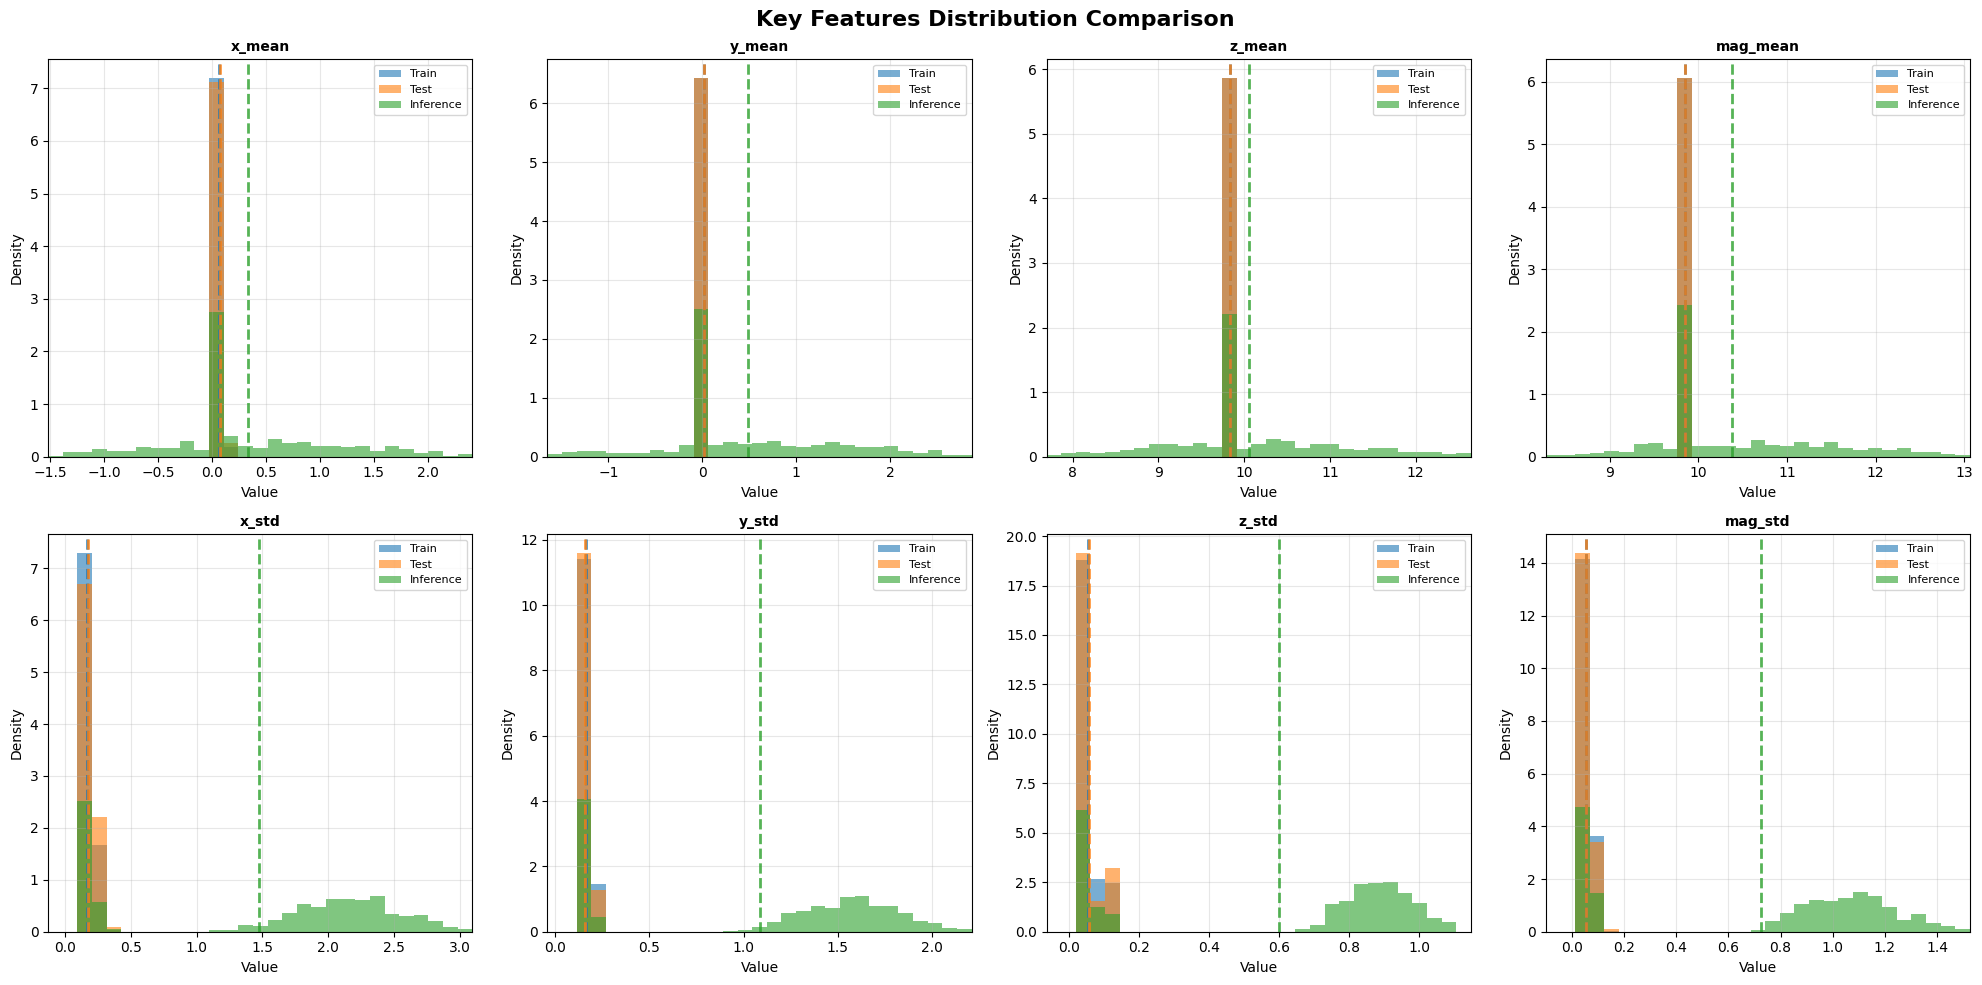

Feature distribution analysis completed
Total features analyzed: 41
Key features highlighted: 8


In [8]:
# Feature distribution visualization
n_features = len(signal_features)
n_cols = 6
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 4*n_rows))
fig.suptitle(f'All {n_features} Features Distribution Comparison', fontsize=16, fontweight='bold')

if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
dataset_names = ['Train', 'Test', 'Inference']

for i, feature in enumerate(signal_features):
    ax = axes[i]
    
    all_data = []
    for dataset_key in feature_data.keys():
        all_data.extend(feature_data[dataset_key][feature].values)
    
    p1, p99 = np.percentile(all_data, [1, 99])
    data_range = p99 - p1
    bins = np.linspace(p1 - 0.1 * data_range, p99 + 0.1 * data_range, 20)
    
    for j, (dataset_key, dataset_name) in enumerate(zip(feature_data.keys(), dataset_names)):
        data = feature_data[dataset_key][feature]
        ax.hist(data, bins=bins, alpha=0.6, color=colors[j], label=dataset_name, density=True)
        mean_val = data.mean()
        ax.axvline(mean_val, color=colors[j], linestyle='--', alpha=0.8, linewidth=1)
    
    ax.set_title(f'{feature}', fontweight='bold', fontsize=9)
    ax.set_xlabel('Value', fontsize=8)
    ax.set_ylabel('Density', fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=7)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(p1 - 0.1 * data_range, p99 + 0.1 * data_range)
    
    if i == 0:
        ax.legend(fontsize=8)

for i in range(n_features, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# Key features focused view
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Key Features Distribution Comparison', fontsize=16, fontweight='bold')

for i, feature in enumerate(key_features):
    ax = axes[i//4, i%4]
    
    all_data = []
    for dataset_key in feature_data.keys():
        all_data.extend(feature_data[dataset_key][feature].values)
    
    p1, p99 = np.percentile(all_data, [1, 99])
    data_range = p99 - p1
    bins = np.linspace(p1 - 0.1 * data_range, p99 + 0.1 * data_range, 30)
    
    for j, (dataset_key, dataset_name) in enumerate(zip(feature_data.keys(), dataset_names)):
        data = feature_data[dataset_key][feature]
        ax.hist(data, bins=bins, alpha=0.6, color=colors[j], label=dataset_name, density=True)
        mean_val = data.mean()
        ax.axvline(mean_val, color=colors[j], linestyle='--', alpha=0.8, linewidth=2)
    
    ax.set_title(f'{feature}', fontweight='bold', fontsize=10)
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(p1 - 0.1 * data_range, p99 + 0.1 * data_range)

plt.tight_layout()
plt.show()

print("Feature distribution analysis completed")
print(f"Total features analyzed: {len(signal_features)}")
print(f"Key features highlighted: {len(key_features)}")

In [9]:
# Determine where to grab the importances from
if hasattr(model, "feature_importances_"):
    raw_importances = model.feature_importances_
elif hasattr(model, "model") and hasattr(model.model, "feature_importances_"):
    raw_importances = model.model.feature_importances_
else:
    raise AttributeError("No feature_importances_ found on `model` or `model.model`")

# Build a pandas Series for easy sorting & display
importances = pd.Series(raw_importances, index=signal_features)
importances = importances.sort_values(ascending=False)

# Show the top features
print("Top 20 feature importances:")
print(importances.head(20))


Top 20 feature importances:
max_delta_mag    0.096817
y_max            0.078466
mag_std          0.067870
y_mean           0.058454
y_fft_mean       0.044333
y_energy         0.044312
y_kurtosis       0.040620
y_range          0.038016
z_skew           0.031380
y_skew           0.031199
x_max            0.027614
yz_corr          0.027456
z_std            0.027123
x_fft_mean       0.026691
z_mean           0.025551
x_kurtosis       0.024453
x_mean           0.024392
x_skew           0.022741
x_energy         0.021857
z_kurtosis       0.019540
dtype: float64


# 4. Drift Detection Analysis



### 4.1 Quantify drift

  Processed 100/473 samples
  Processed 200/473 samples
  Processed 300/473 samples
  Processed 400/473 samples


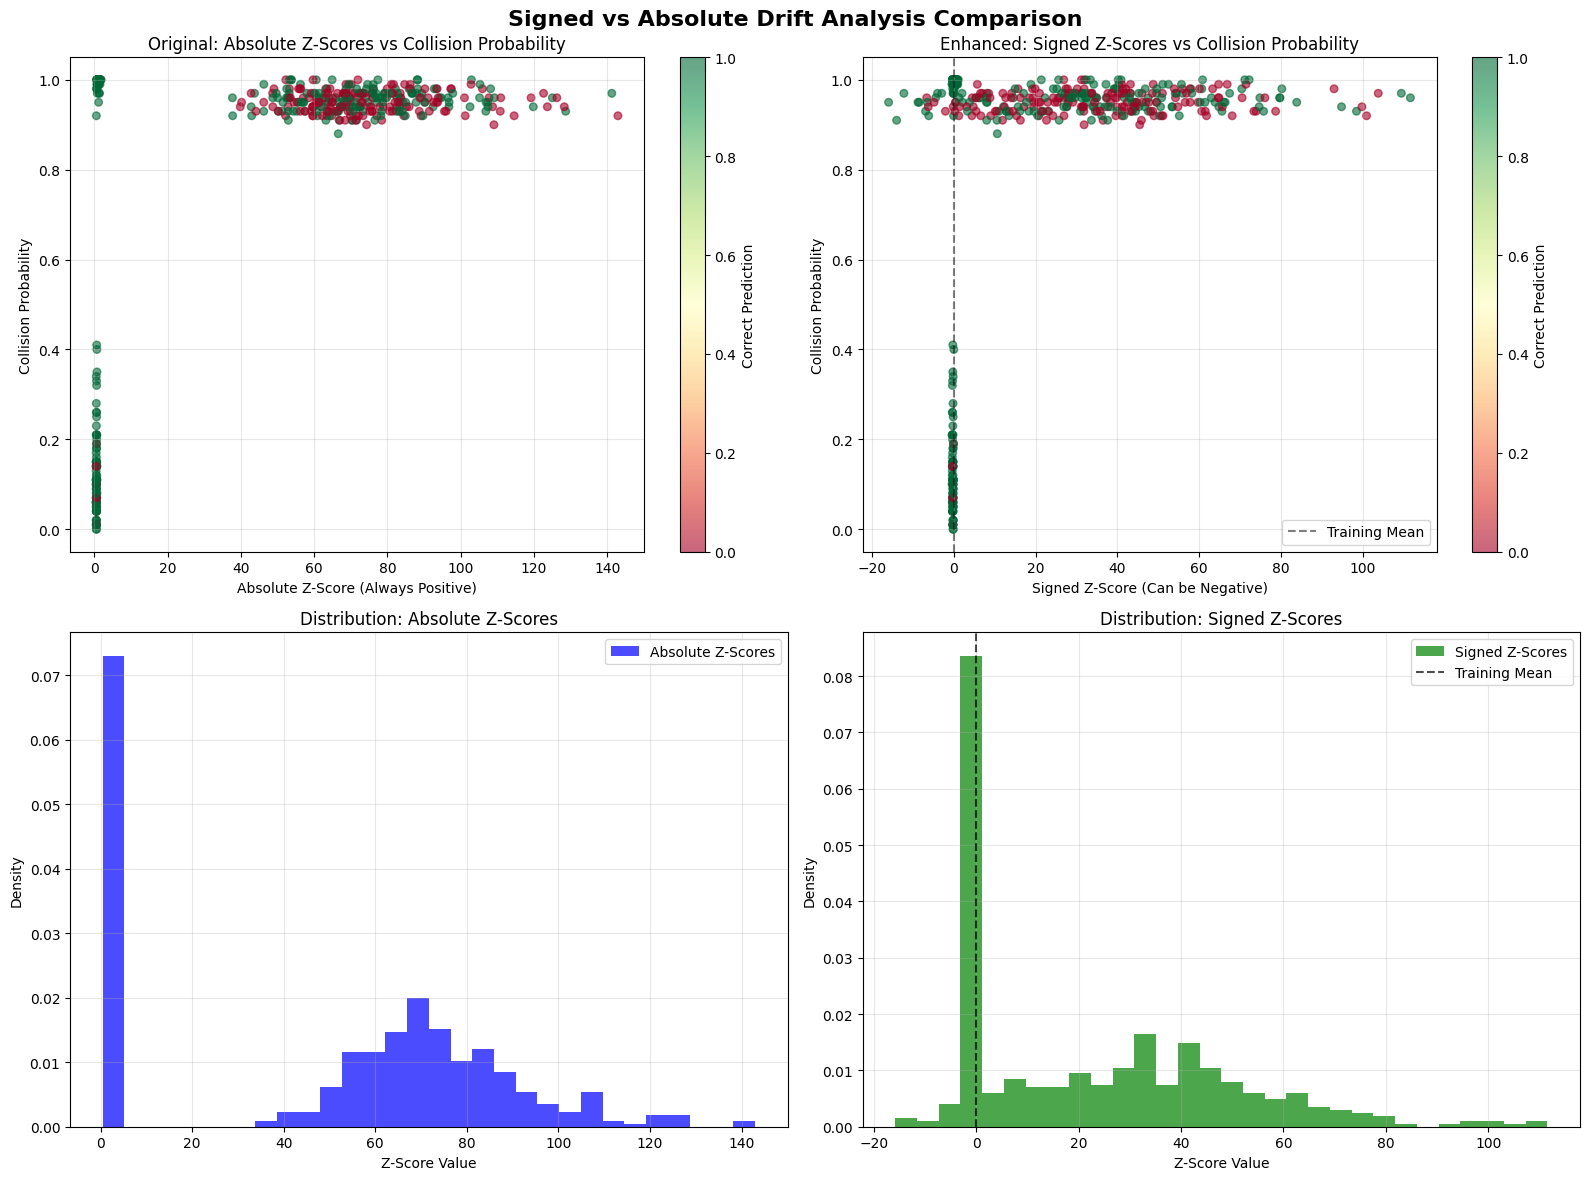

In [10]:
# Calculate drift scores for each sample (INCLUDING NEGATIVE VALUES)


from sklearn.covariance import EmpiricalCovariance
from scipy.spatial.distance import mahalanobis
import numpy as np

def calculate_drift_scores_signed(train_data, inference_data, features):
    """Calculate drift scores including NEGATIVE values for directional analysis"""
    
    
    # Get training statistics
    train_features = train_data[features]
    train_mean = train_features.mean()
    train_std = train_features.std()
    train_cov = train_features.cov()
    
  
    
    inference_features = inference_data[features]
    n_samples = len(inference_features)
    
    drift_scores = []
    
    for idx, (_, sample) in enumerate(inference_features.iterrows()):
        sample_values = sample.values
        
    
        
        # SIGNED Z-scores (preserve direction: positive = above mean, negative = below mean)
        z_scores_signed = (sample_values - train_mean.values) / (train_std.values + 1e-10)
        
        # Different aggregation methods for signed z-scores
        avg_z_score_signed = np.mean(z_scores_signed)  # Can be positive or negative
        avg_z_score_abs = np.mean(np.abs(z_scores_signed))  # Always positive (original)
        max_z_score_abs = np.max(np.abs(z_scores_signed))
        
        # Directional measures
        positive_deviations = np.sum(z_scores_signed > 0)
        negative_deviations = np.sum(z_scores_signed < 0)
        extreme_positive = np.sum(z_scores_signed > 3.0)
        extreme_negative = np.sum(z_scores_signed < -3.0)
        
        # Composite scores
        composite_score_signed = avg_z_score_signed  # New: can be negative
        
        drift_scores.append({
            'sample_index': idx,
            'sample_id': inference_data.iloc[idx]['sample_id'],
            'avg_z_score_signed': avg_z_score_signed,           # NEW: Can be negative
            'avg_z_score_abs': avg_z_score_abs,                 # Original: Always positive
            'max_z_score_abs': max_z_score_abs,
            'positive_deviations': positive_deviations,
            'negative_deviations': negative_deviations,
            'extreme_positive': extreme_positive,
            'extreme_negative': extreme_negative,
            'composite_score_signed': composite_score_signed,   # NEW: Can be negative
            'z_scores_signed': z_scores_signed                  # Store full signed z-score array
        })
        
        if (idx + 1) % 100 == 0:
            print(f"  Processed {idx + 1}/{n_samples} samples")
    
    return pd.DataFrame(drift_scores)

# Calculate signed drift scores
drift_scores_signed_df = calculate_drift_scores_signed(test_df, inference_merged, signal_features)


fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Signed vs Absolute Drift Analysis Comparison', fontsize=16, fontweight='bold')

# Get model predictions for coloring
y_true = inference_merged['label']
X_inference = inference_merged[signal_features]
y_pred = model.predict(X_inference)
y_pred_proba = model.predict_proba(X_inference)
collision_idx = np.where(model.label_encoder.classes_ == 'collision')[0][0]
collision_probs = y_pred_proba[:, collision_idx]
correct_predictions = (y_true == y_pred)

# Plot 1: Absolute Z-scores (Original)
ax1 = axes[0, 0]
scatter1 = ax1.scatter(drift_scores_signed_df['avg_z_score_abs'], collision_probs,
                      c=correct_predictions, cmap='RdYlGn', alpha=0.6, s=30)
ax1.set_xlabel('Absolute Z-Score (Always Positive)')
ax1.set_ylabel('Collision Probability')
ax1.set_title('Original: Absolute Z-Scores vs Collision Probability')
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=ax1, label='Correct Prediction')

# Plot 2: Signed Z-scores (New)
ax2 = axes[0, 1]
scatter2 = ax2.scatter(drift_scores_signed_df['avg_z_score_signed'], collision_probs,
                      c=correct_predictions, cmap='RdYlGn', alpha=0.6, s=30)
ax2.set_xlabel('Signed Z-Score (Can be Negative)')
ax2.set_ylabel('Collision Probability')
ax2.set_title('Enhanced: Signed Z-Scores vs Collision Probability')
ax2.axvline(x=0, color='black', linestyle='--', alpha=0.5, label='Training Mean')
ax2.grid(True, alpha=0.3)
ax2.legend()
plt.colorbar(scatter2, ax=ax2, label='Correct Prediction')

# Plot 3: Distribution comparison
ax3 = axes[1, 0]
ax3.hist(drift_scores_signed_df['avg_z_score_abs'], bins=30, alpha=0.7, 
         color='blue', label='Absolute Z-Scores', density=True)
ax3.set_xlabel('Z-Score Value')
ax3.set_ylabel('Density')
ax3.set_title('Distribution: Absolute Z-Scores')
ax3.legend()
ax3.grid(True, alpha=0.3)

ax4 = axes[1, 1]
ax4.hist(drift_scores_signed_df['avg_z_score_signed'], bins=30, alpha=0.7, 
         color='green', label='Signed Z-Scores', density=True)
ax4.axvline(x=0, color='black', linestyle='--', alpha=0.7, label='Training Mean')
ax4.set_xlabel('Z-Score Value')
ax4.set_ylabel('Density')
ax4.set_title('Distribution: Signed Z-Scores')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


  Processed 100/800 samples
  Processed 200/800 samples
  Processed 300/800 samples
  Processed 400/800 samples
  Processed 500/800 samples
  Processed 600/800 samples
  Processed 700/800 samples
  Processed 800/800 samples
  Processed 100/200 samples
  Processed 200/200 samples


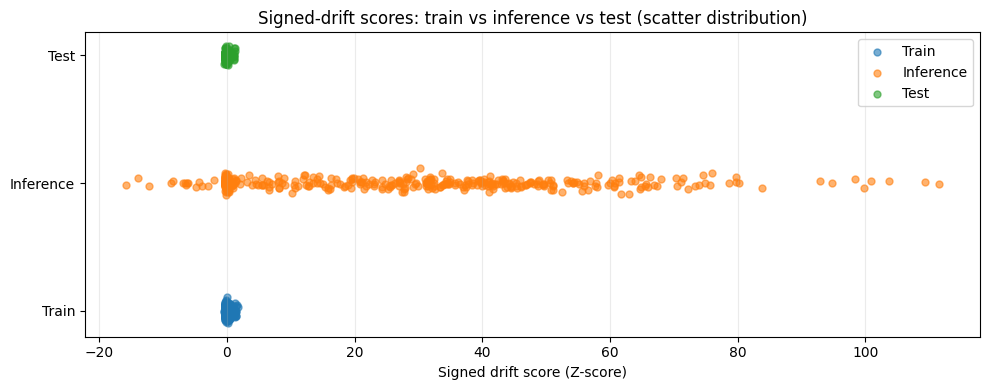

In [11]:
drift_scores_signed_df_on_train = calculate_drift_scores_signed(train_df, train_df, signal_features)
drift_scores_signed_df_on_test = calculate_drift_scores_signed(test_df, test_df, signal_features)

# ❶ Extract the signed-drift scores
train_scores = drift_scores_signed_df_on_train["avg_z_score_signed"]
inf_scores   = drift_scores_signed_df["avg_z_score_signed"]
test_scores  = drift_scores_signed_df_on_test["avg_z_score_signed"]

# ❷ Create three horizontal “rows” with a bit of vertical jitter
y_train = np.random.normal(0, 0.03, size=len(train_scores))   # around y=0
y_inf   = np.random.normal(1, 0.03, size=len(inf_scores))     # around y=1
y_test  = np.random.normal(2, 0.03, size=len(test_scores))    # around y=2

plt.figure(figsize=(10, 4))

plt.scatter(train_scores, y_train,
            color="#1f77b4", alpha=0.6, s=25, label="Train")
plt.scatter(inf_scores,   y_inf,
            color="#ff7f0e", alpha=0.6, s=25, label="Inference")
plt.scatter(test_scores,  y_test,
            color="#2ca02c", alpha=0.6, s=25, label="Test")

plt.yticks([0, 1, 2], ["Train", "Inference", "Test"])
plt.xlabel("Signed drift score (Z-score)")
plt.title("Signed-drift scores: train vs inference vs test (scatter distribution)")
plt.legend()
plt.grid(True, axis="x", alpha=0.25)
plt.tight_layout()
plt.show()



### 4.2 Performance Analysis by Drift Category
Classify individual data points into drift categories and analyze model performance.

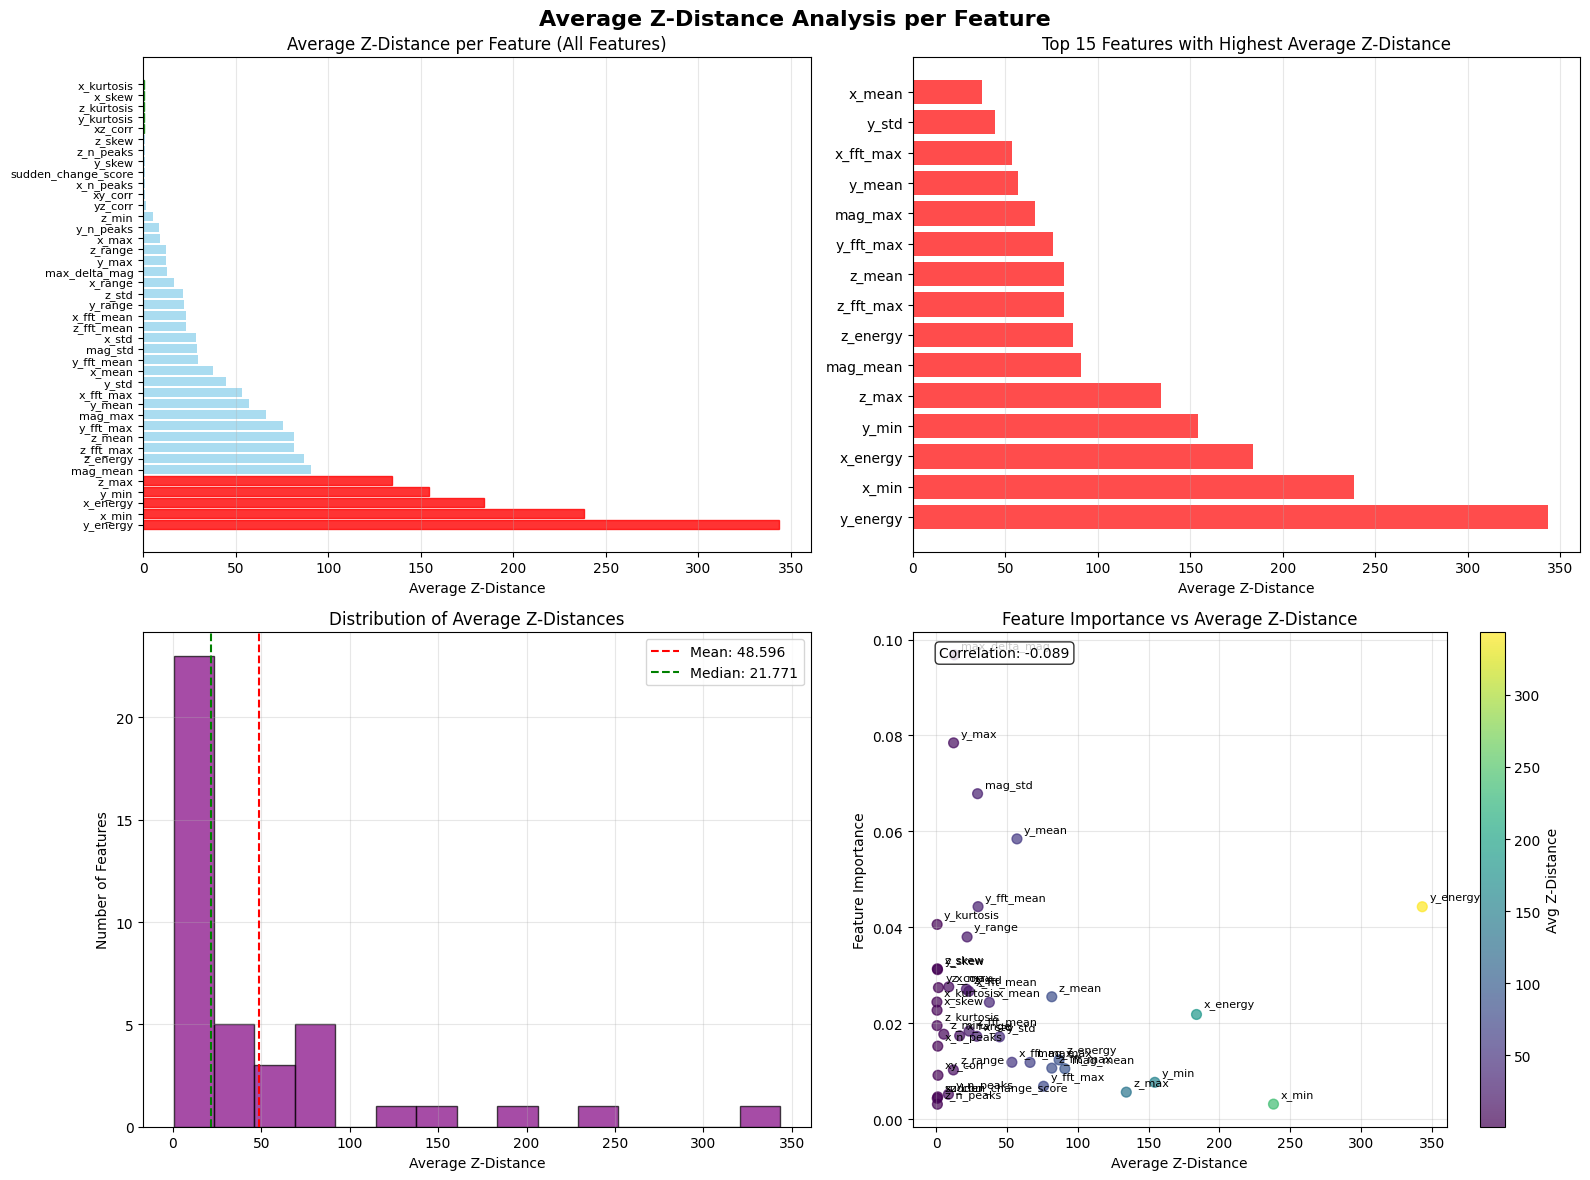

In [12]:

# Use training data statistics as baseline
train_features = train_df[signal_features]
train_mean = train_features.mean()
train_std = train_features.std()

# Get inference features
inference_features = inference_merged[signal_features]


# Calculate z-distance for each feature across all samples
feature_z_distances = {}

for feature in signal_features:
    # Calculate z-scores for this feature across all inference samples
    feature_values = inference_features[feature].values
    train_feature_mean = train_mean[feature]
    train_feature_std = train_std[feature]
    
    # Calculate z-scores (absolute values for distance)
    z_scores = np.abs((feature_values - train_feature_mean) / (train_feature_std + 1e-10))
    
    # Calculate average z-distance for this feature
    avg_z_distance = np.mean(z_scores)
    
    feature_z_distances[feature] = {
        'avg_z_distance': avg_z_distance,
        'max_z_distance': np.max(z_scores),
        'min_z_distance': np.min(z_scores),
        'std_z_distance': np.std(z_scores),
        'median_z_distance': np.median(z_scores)
    }

# Convert to DataFrame for easier analysis
feature_distance_df = pd.DataFrame(feature_z_distances).T
feature_distance_df = feature_distance_df.sort_values('avg_z_distance', ascending=False)



fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Average Z-Distance Analysis per Feature', fontsize=16, fontweight='bold')

# Plot 1: Bar chart of all features
ax1 = axes[0, 0]
y_pos = np.arange(len(feature_distance_df))
bars = ax1.barh(y_pos, feature_distance_df['avg_z_distance'].values, alpha=0.7, color='skyblue')
ax1.set_yticks(y_pos)
ax1.set_yticklabels(feature_distance_df.index, fontsize=8)
ax1.set_xlabel('Average Z-Distance')
ax1.set_title('Average Z-Distance per Feature (All Features)')
ax1.grid(True, alpha=0.3, axis='x')

# Highlight top and bottom features
for i, bar in enumerate(bars):
    if i < 5:  # Top 5
        bar.set_color('red')
        bar.set_alpha(0.8)
    elif i >= len(bars) - 5:  # Bottom 5
        bar.set_color('green')
        bar.set_alpha(0.8)

# Plot 2: Top 15 features only
ax2 = axes[0, 1]
top_15 = feature_distance_df.head(15)
y_pos_top = np.arange(len(top_15))
ax2.barh(y_pos_top, top_15['avg_z_distance'].values, alpha=0.7, color='red')
ax2.set_yticks(y_pos_top)
ax2.set_yticklabels(top_15.index, fontsize=10)
ax2.set_xlabel('Average Z-Distance')
ax2.set_title('Top 15 Features with Highest Average Z-Distance')
ax2.grid(True, alpha=0.3, axis='x')

# Plot 3: Distribution of z-distances
ax3 = axes[1, 0]
ax3.hist(feature_distance_df['avg_z_distance'], bins=15, alpha=0.7, color='purple', edgecolor='black')
ax3.axvline(feature_distance_df['avg_z_distance'].mean(), color='red', linestyle='--', 
           label=f'Mean: {feature_distance_df["avg_z_distance"].mean():.3f}')
ax3.axvline(feature_distance_df['avg_z_distance'].median(), color='green', linestyle='--',
           label=f'Median: {feature_distance_df["avg_z_distance"].median():.3f}')
ax3.set_xlabel('Average Z-Distance')
ax3.set_ylabel('Number of Features')
ax3.set_title('Distribution of Average Z-Distances')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Scatter plot with feature importance (if available)
ax4 = axes[1, 1]
if hasattr(model, 'feature_importances_') or (hasattr(model, 'model') and hasattr(model.model, 'feature_importances_')):
    # Get feature importances
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        importances = model.model.feature_importances_
    
    importance_series = pd.Series(importances, index=signal_features)
    
    # Merge with z-distance data
    merged_data = feature_distance_df.copy()
    merged_data['importance'] = merged_data.index.map(importance_series)
    
    # Create scatter plot
    scatter = ax4.scatter(merged_data['avg_z_distance'], merged_data['importance'], 
                         alpha=0.7, s=50, c=merged_data['avg_z_distance'], cmap='viridis')
    
    # # Add feature labels for top drift features
    # top_5_drift = merged_data.nlargest(5, 'avg_z_distance')
    # for feature, row in top_5_drift.iterrows():
    #     ax4.annotate(feature, (row['avg_z_distance'], row['importance']), 
    #                 xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    for feature, row in merged_data.iterrows():
        ax4.annotate(feature, (row['avg_z_distance'], row['importance']), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)



    
    ax4.set_xlabel('Average Z-Distance')
    ax4.set_ylabel('Feature Importance')
    ax4.set_title('Feature Importance vs Average Z-Distance')
    ax4.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax4, label='Avg Z-Distance')
    
    # Calculate correlation
    correlation = merged_data[['avg_z_distance', 'importance']].corr().iloc[0, 1]
    ax4.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
            transform=ax4.transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
else:
    ax4.text(0.5, 0.5, 'Feature importances\nnot available', 
            transform=ax4.transAxes, ha='center', va='center', fontsize=12)
    ax4.set_title('Feature Importance vs Z-Distance\n(Not Available)')

plt.tight_layout()
plt.show()


In [13]:
# Calculate missing columns for drift_scores_signed_df
print("Adding missing columns to drift_scores_signed_df...")

# Get model predictions for inference data
X_inference = inference_merged[signal_features]
y_pred = model.predict(X_inference)
y_pred_proba = model.predict_proba(X_inference)

# Get collision probabilities
collision_idx = np.where(model.label_encoder.classes_ == 'collision')[0][0]
collision_probs = y_pred_proba[:, collision_idx]

# Get prediction confidence (max probability)
confidence_levels = np.max(y_pred_proba, axis=1)

# Get true labels
true_labels = inference_merged['label']

# Get predicted labels
predicted_labels = y_pred

# Add the new columns to drift_scores_signed_df
drift_scores_signed_df['collision_probability'] = collision_probs
drift_scores_signed_df['prediction_confidence'] = confidence_levels
drift_scores_signed_df['true_label'] = true_labels.values
drift_scores_signed_df['predicted_label'] = predicted_labels

print(f"Added 4 new columns to drift_scores_signed_df")
print(f"New shape: {drift_scores_signed_df.shape}")
print(f"New columns: {drift_scores_signed_df.columns.tolist()}")

# Verify the new columns
print(f"\nColumn verification:")
print(f"collision_probability range: {drift_scores_signed_df['collision_probability'].min():.3f} to {drift_scores_signed_df['collision_probability'].max():.3f}")
print(f"prediction_confidence range: {drift_scores_signed_df['prediction_confidence'].min():.3f} to {drift_scores_signed_df['prediction_confidence'].max():.3f}")
print(f"true_label unique values: {drift_scores_signed_df['true_label'].unique()}")
print(f"predicted_label unique values: {drift_scores_signed_df['predicted_label'].unique()}")

# Show sample of the updated dataframe
print(f"\nSample of updated drift_scores_signed_df:")
print(drift_scores_signed_df[['sample_id', 'collision_probability', 'prediction_confidence', 'true_label', 'predicted_label']].head())

Adding missing columns to drift_scores_signed_df...
Added 4 new columns to drift_scores_signed_df
New shape: (473, 15)
New columns: ['sample_index', 'sample_id', 'avg_z_score_signed', 'avg_z_score_abs', 'max_z_score_abs', 'positive_deviations', 'negative_deviations', 'extreme_positive', 'extreme_negative', 'composite_score_signed', 'z_scores_signed', 'collision_probability', 'prediction_confidence', 'true_label', 'predicted_label']

Column verification:
collision_probability range: 0.000 to 1.000
prediction_confidence range: 0.590 to 1.000
true_label unique values: ['normal' 'collision']
predicted_label unique values: ['normal' 'collision']

Sample of updated drift_scores_signed_df:
                              sample_id  collision_probability  \
0  0143cf13-fd51-44fd-8dd4-c2c92f5db7bd                   0.06   
1  01b5f718-2978-468f-9789-89003ba755e6                   1.00   
2  01fb46f8-2dc1-4bd3-a823-252a87c3bd03                   0.98   
3  022ae887-3b50-4440-94af-446a1cec3f87     

In [14]:
# Enhanced drift analysis with updated thresholds
print("ENHANCED DRIFT CLASSIFICATION")
print("="*60)

# Use the Average Z-Score method (best performing from previous analysis)
avg_z_scores = drift_scores_signed_df['avg_z_score_signed']

# Updated thresholds (more realistic for real-world application)
updated_thresholds = {
    'in_distribution': 1,    # More inclusive threshold
    'complete_ood': 1       # Much higher threshold for complete OOD
}

print(f"Using updated thresholds:")
print(f"  In Distribution: < {updated_thresholds['in_distribution']}")
print(f"  Complete OOD: >= {updated_thresholds['complete_ood']}")

# Classify samples with updated thresholds
def classify_drift_updated(z_score):
    if z_score < updated_thresholds['in_distribution']:
        return 'In Distribution'
    elif z_score >= updated_thresholds['complete_ood']:
        return 'Complete OOD'


# Apply classification
drift_classification = np.array([classify_drift_updated(z) for z in avg_z_scores])

# Distribution of classifications
drift_dist = pd.Series(drift_classification).value_counts()
print("\nDrift Classification Distribution:")
for category, count in drift_dist.items():
    pct = (count / len(drift_classification)) * 100
    print(f"  {category}: {count} samples ({pct:.1f}%)")

# Get model predictions and performance data
collision_probs = drift_scores_signed_df['collision_probability']
confidence_levels = drift_scores_signed_df['prediction_confidence']
true_labels = drift_scores_signed_df['true_label']
predicted_labels = drift_scores_signed_df['predicted_label']

# Performance by updated drift category
print("\nModel Performance by Updated Drift Category:")
for category in ['In Distribution', 'Complete OOD']:
    mask = drift_classification == category
    if np.sum(mask) > 0:
        cat_accuracy = accuracy_score(true_labels[mask], predicted_labels[mask])
        cat_recall = recall_score(true_labels[mask], predicted_labels[mask], average='weighted')
        cat_collision_rate = np.mean(true_labels[mask] == 'collision')
        cat_confidence = np.mean(confidence_levels[mask])
        print(f"  {category}: {np.sum(mask)} samples, Accuracy: {cat_accuracy:.3f}, Recall: {cat_recall:.3f}, "
              f"Collision Rate: {cat_collision_rate:.3f}, Avg Confidence: {cat_confidence:.3f}")
    else:
        print(f"  {category}: 0 samples")

ENHANCED DRIFT CLASSIFICATION
Using updated thresholds:
  In Distribution: < 1
  Complete OOD: >= 1

Drift Classification Distribution:
  Complete OOD: 292 samples (61.7%)
  In Distribution: 181 samples (38.3%)

Model Performance by Updated Drift Category:
  In Distribution: 181 samples, Accuracy: 0.906, Recall: 0.906, Collision Rate: 0.525, Avg Confidence: 0.932
  Complete OOD: 292 samples, Accuracy: 0.483, Recall: 0.483, Collision Rate: 0.483, Avg Confidence: 0.953


### 4.3 Threshold Classification

ENHANCED SCATTER PLOT: DRIFT vs TRUE LABELS


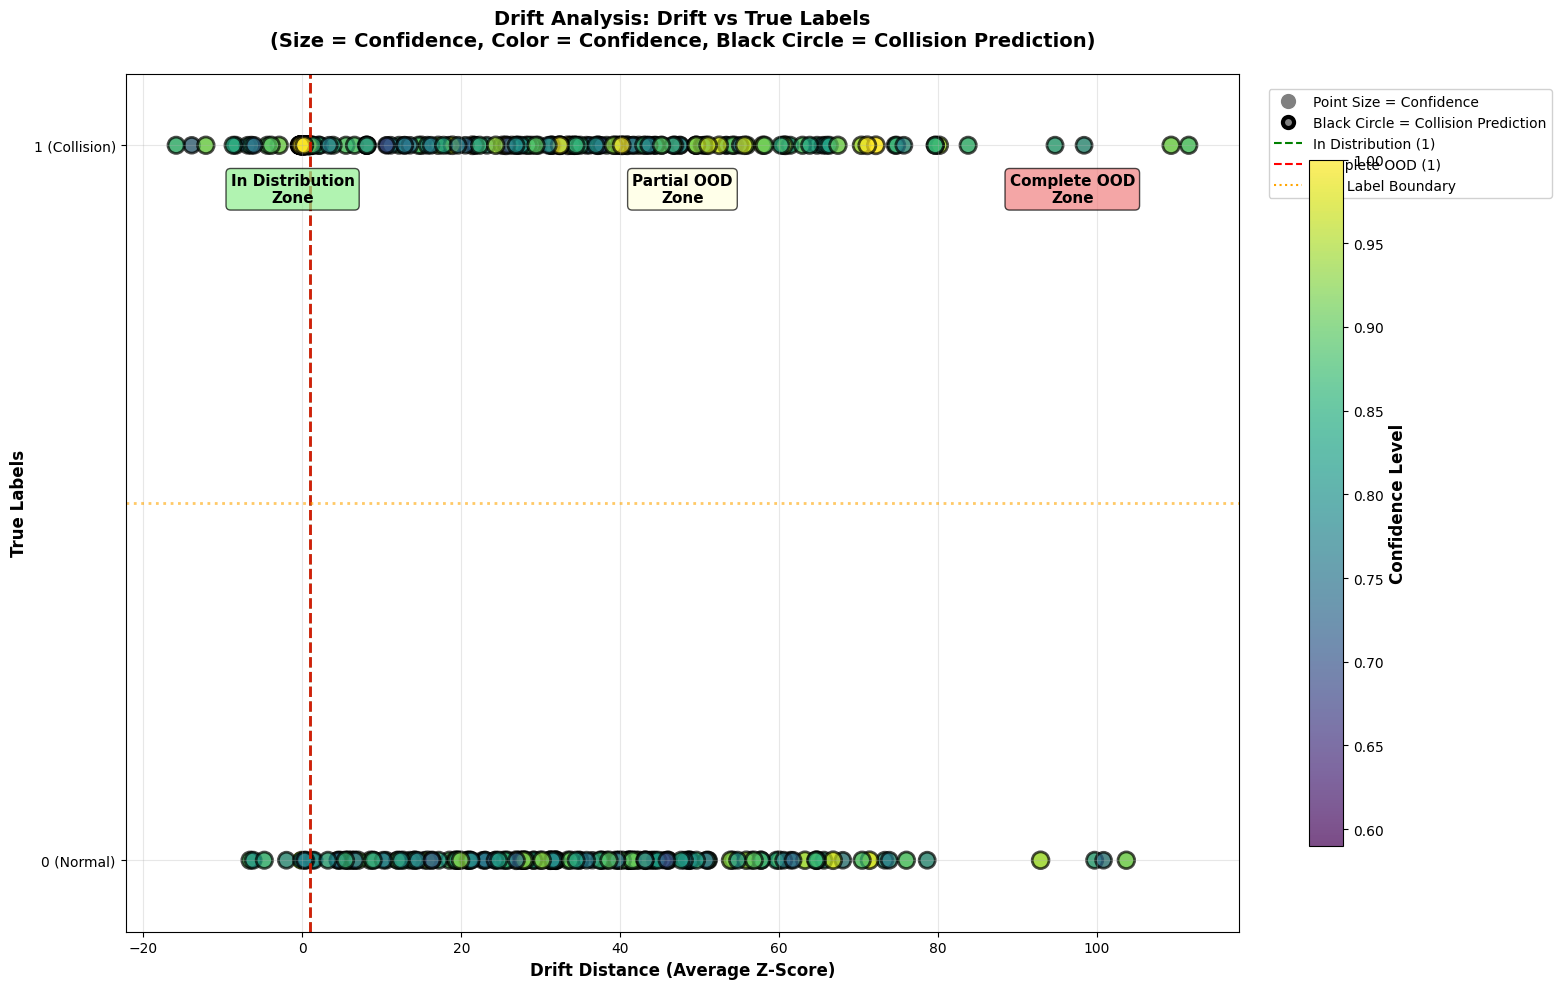


PREDICTION vs TRUE LABEL ANALYSIS:
Prediction vs True Label Cross-tabulation:
predicted_label  collision  normal  All
true_label                             
collision              226      10  236
normal                 158      79  237
All                    384      89  473

Prediction Analysis by Drift Zone:

In Distribution Zone:
  Total samples: 181
  Collision predictions: 92 (50.8%)
  True collisions: 95
  Avg confidence: 0.932
  Accuracy: 0.906

Complete OOD Zone:
  Total samples: 292
  Collision predictions: 292 (100.0%)
  True collisions: 141
  Avg confidence: 0.953
  Accuracy: 0.483

UPDATED DRIFT SCORE RANGES AND CLASSIFICATION:
Drift Score Percentiles:
  10th percentile: -0.244 (In Distribution)
  25th percentile: -0.079 (In Distribution)
  50th percentile: 17.172 (Complete OOD)
  75th percentile: 41.056 (Complete OOD)
  90th percentile: 58.138 (Complete OOD)
  95th percentile: 68.972 (Complete OOD)
  99th percentile: 98.769 (Complete OOD)

Summary Statistics by Updated 

In [15]:
# Enhanced visualization: drift vs true labels with confidence coloring and collision prediction circles
print("ENHANCED SCATTER PLOT: DRIFT vs TRUE LABELS")
print("="*50)

# Create numeric mapping for true labels (Y-axis)
label_mapping = {'normal': 0, 'collision': 1}
true_labels_numeric = np.array([label_mapping[label] for label in true_labels])

# Scale confidence values for point sizes (minimum size 50, maximum size 150)
min_size, max_size = 50, 150
confidence_sizes = min_size + (confidence_levels - confidence_levels.min()) * (max_size - min_size) / (confidence_levels.max() - confidence_levels.min())

# Create masks for collision predictions
collision_predictions = (predicted_labels == 'collision')

# Create the enhanced scatter plot with larger figure
plt.figure(figsize=(16, 10))

# First, plot all points with confidence as color
scatter = plt.scatter(avg_z_scores, true_labels_numeric, 
                     c=confidence_levels, 
                     cmap='viridis',  # Confidence level color mapping
                     alpha=0.7, 
                     s=confidence_sizes,
                     edgecolors='none',  # No edge initially
                     linewidth=0)

# Add thick black circles around collision predictions
collision_scatter = plt.scatter(avg_z_scores[collision_predictions], 
                               true_labels_numeric[collision_predictions], 
                               c=confidence_levels[collision_predictions], 
                               cmap='viridis',
                               alpha=0.7, 
                               s=confidence_sizes[collision_predictions],
                               edgecolors='black',  # Thick black edge for collision predictions
                               linewidth=2)

# Add colorbar for confidence levels
cbar = plt.colorbar(scatter, shrink=0.8)
cbar.set_label('Confidence Level', fontsize=12, fontweight='bold')

# Add vertical lines for updated drift thresholds
plt.axvline(x=updated_thresholds['in_distribution'], color='green', linestyle='--', 
           alpha=0.8, linewidth=2, label=f'In Distribution ({updated_thresholds["in_distribution"]})')
plt.axvline(x=updated_thresholds['complete_ood'], color='red', linestyle='--', 
           alpha=0.8, linewidth=2, label=f'Complete OOD ({updated_thresholds["complete_ood"]})')

# Add horizontal reference line between true labels
plt.axhline(y=0.5, color='orange', linestyle=':', alpha=0.6, linewidth=2, 
           label='True Label Boundary')

# Add zone annotations (repositioned for new thresholds)
plt.text(0.15, 0.85, 'In Distribution\nZone', fontsize=11, fontweight='bold', 
         bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgreen', alpha=0.7),
         ha='center', transform=plt.gca().transAxes)

plt.text(0.5, 0.85, 'Partial OOD\nZone', fontsize=11, fontweight='bold',
         bbox=dict(boxstyle="round,pad=0.3", facecolor='lightyellow', alpha=0.7),
         ha='center', transform=plt.gca().transAxes)

plt.text(0.85, 0.85, 'Complete OOD\nZone', fontsize=11, fontweight='bold',
         bbox=dict(boxstyle="round,pad=0.3", facecolor='lightcoral', alpha=0.7),
         ha='center', transform=plt.gca().transAxes)

# Add legend explanations
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
               markersize=12, label='Point Size = Confidence'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
               markeredgecolor='black', markeredgewidth=3, markersize=8, 
               label='Black Circle = Collision Prediction'),
    plt.Line2D([0], [0], color='green', linestyle='--', 
               label=f'In Distribution ({updated_thresholds["in_distribution"]})'),
    plt.Line2D([0], [0], color='red', linestyle='--', 
               label=f'Complete OOD ({updated_thresholds["complete_ood"]})'),
    plt.Line2D([0], [0], color='orange', linestyle=':', 
               label='True Label Boundary')
]

# Styling
plt.xlabel('Drift Distance (Average Z-Score)', fontsize=12, fontweight='bold')
plt.ylabel('True Labels', fontsize=12, fontweight='bold')
plt.title('Drift Analysis: Drift vs True Labels\n(Size = Confidence, Color = Confidence, Black Circle = Collision Prediction)', 
          fontsize=14, fontweight='bold', pad=20)

# Set Y-axis labels
plt.yticks([0, 1], ['0 (Normal)', '1 (Collision)'])
plt.ylim(-0.1, 1.1)

# Position legend to avoid overlap
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 0.99), framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Add analysis of predictions vs true labels
print("\nPREDICTION vs TRUE LABEL ANALYSIS:")
print("="*50)

# Count collision predictions by true label
collision_pred_by_true = pd.crosstab(true_labels, predicted_labels, margins=True)
print("Prediction vs True Label Cross-tabulation:")
print(collision_pred_by_true)

# Calculate prediction accuracy by drift zone
print("\nPrediction Analysis by Drift Zone:")
for category in ['In Distribution', 'Partial OOD', 'Complete OOD']:
    mask = drift_classification == category
    if np.sum(mask) > 0:
        zone_true = true_labels[mask]
        zone_pred = predicted_labels[mask]
        zone_confidence = confidence_levels[mask]
        
        # Count collision predictions in this zone
        collision_pred_count = np.sum(zone_pred == 'collision')
        total_count = len(zone_pred)
        
        print(f"\n{category} Zone:")
        print(f"  Total samples: {total_count}")
        print(f"  Collision predictions: {collision_pred_count} ({collision_pred_count/total_count*100:.1f}%)")
        print(f"  True collisions: {np.sum(zone_true == 'collision')}")
        print(f"  Avg confidence: {zone_confidence.mean():.3f}")
        
        # Accuracy in this zone
        zone_accuracy = accuracy_score(zone_true, zone_pred)
        print(f"  Accuracy: {zone_accuracy:.3f}")

# Updated drift score ranges and classification
print("\nUPDATED DRIFT SCORE RANGES AND CLASSIFICATION:")
print("="*60)

# Calculate percentiles for drift scores
drift_percentiles = [10, 25, 50, 75, 90, 95, 99]
drift_values = [np.percentile(avg_z_scores, p) for p in drift_percentiles]

print("Drift Score Percentiles:")
for p, v in zip(drift_percentiles, drift_values):
    if v < updated_thresholds['in_distribution']:
        classification = "In Distribution"
    elif v < updated_thresholds['complete_ood']:
        classification = "Partial OOD"
    else:
        classification = "Complete OOD"
    print(f"  {p:2d}th percentile: {v:6.3f} ({classification})")

# Summary statistics by updated zones
print("\nSummary Statistics by Updated Drift Zone:")
for category in ['In Distribution', 'Partial OOD', 'Complete OOD']:
    mask = drift_classification == category
    if np.sum(mask) > 0:
        zone_collision_prob = np.mean(collision_probs[mask])
        zone_confidence = np.mean(confidence_levels[mask])
        zone_drift = np.mean(avg_z_scores[mask])
        zone_accuracy = accuracy_score(true_labels[mask], predicted_labels[mask])
        
        print(f"\n{category} Zone:")
        print(f"  Samples: {np.sum(mask)}")
        print(f"  Avg Drift Distance: {zone_drift:.3f}")
        print(f"  Avg Collision Probability: {zone_collision_prob:.3f}")
        print(f"  Avg Confidence: {zone_confidence:.3f}")
        print(f"  Model Accuracy: {zone_accuracy:.3f}")
    else:
        print(f"\n{category} Zone: 0 samples")

# Appendix A: Experimental Methods

### A1. Decision Boundary and Threshold Optimization

PROBABILITY BOUNDARIES ANALYSIS
Maximum collision probability for 'normal' predictions: 0.4100
Sample index with max normal probability: 464
Minimum collision probability for 'collision' predictions: 0.8800
Sample index with min collision probability: 305


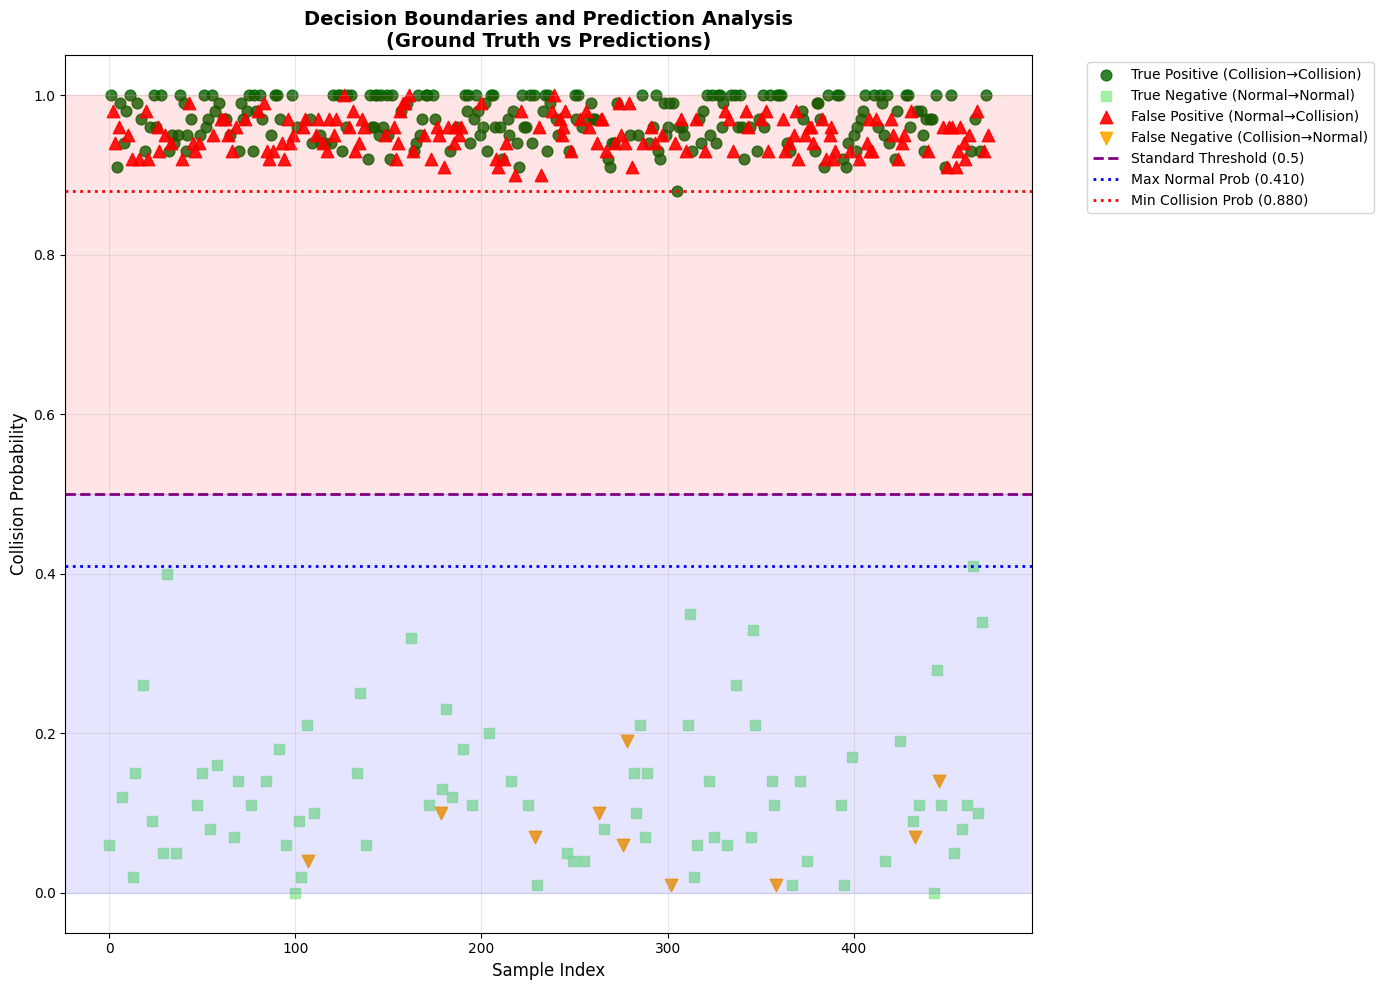

In [16]:

# Find maximum probability for "Normal" and minimum probability for "Collision"
import numpy as np

# Get probabilities for collision class 
collision_idx = np.where(model.label_encoder.classes_ == 'collision')[0][0]
collision_probs = probs[:, collision_idx]

# Find where model predicted each class
collision_mask = (preds == 'collision')
normal_mask = (preds == 'normal')

print("PROBABILITY BOUNDARIES ANALYSIS")
print("="*45)

if np.any(normal_mask):
    max_normal_prob = np.max(collision_probs[normal_mask])
    print(f"Maximum collision probability for 'normal' predictions: {max_normal_prob:.4f}")
    max_normal_idx = np.where(normal_mask)[0][np.argmax(collision_probs[normal_mask])] 
    print(f"Sample index with max normal probability: {max_normal_idx}") 
else: 
    print("No 'normal' predictions found")

if np.any(collision_mask):
    min_collision_prob = np.min(collision_probs[collision_mask])
    print(f"Minimum collision probability for 'collision' predictions: {min_collision_prob:.4f}")
    min_collision_idx = np.where(collision_mask)[0][np.argmin(collision_probs[collision_mask])] 
    print(f"Sample index with min collision probability: {min_collision_idx}") 
else: 
    print("No 'collision' predictions found")

# Show the gap between these boundaries
if np.any(normal_mask) and np.any(collision_mask):
    gap = min_collision_prob - max_normal_prob


    actual_threshold = (max_normal_prob + min_collision_prob) / 2

# Get merged data with ground truth
df_merged = df_inf.merge(labels, on='sample_id', how='inner')
y_true = df_merged['label']
y_pred = preds[:len(df_merged)]
y_probs = probs[:len(df_merged)]

# Get collision probabilities
collision_idx = np.where(model.label_encoder.classes_ == 'collision')[0][0]
collision_probs = y_probs[:, collision_idx]

# Create sample indices for x-axis
sample_indices = np.arange(len(y_true))

# Create prediction accuracy masks
correct_mask = (y_true == y_pred)
incorrect_mask = ~correct_mask

# Create class-specific masks
true_collision = (y_true == 'collision')
true_normal = (y_true == 'normal')
pred_collision = (y_pred == 'collision')
pred_normal = (y_pred == 'normal')

# Create combined masks for each case
true_pos = true_collision & pred_collision  # Correct collision prediction
true_neg = true_normal & pred_normal        # Correct normal prediction
false_pos = true_normal & pred_collision    # Wrong: predicted collision, actually normal
false_neg = true_collision & pred_normal    # Wrong: predicted normal, actually collision

# Create the scatter plot
plt.figure(figsize=(14, 10))

# Plot True Positives (Correct Collision)
plt.scatter(sample_indices[true_pos], collision_probs[true_pos],
            c='darkgreen', marker='o', s=60, alpha=0.8,
            label='True Positive (Collision→Collision)')

# Plot True Negatives (Correct Normal)
plt.scatter(sample_indices[true_neg], collision_probs[true_neg],
            c='lightgreen', marker='s', s=60, alpha=0.8,
            label='True Negative (Normal→Normal)')

# Plot False Positives (Wrong: predicted collision)
plt.scatter(sample_indices[false_pos], collision_probs[false_pos],
            c='red', marker='^', s=80, alpha=0.9,
            label='False Positive (Normal→Collision)')

# Plot False Negatives (Wrong: predicted normal)
plt.scatter(sample_indices[false_neg], collision_probs[false_neg],
            c='orange', marker='v', s=80, alpha=0.9,
            label='False Negative (Collision→Normal)')

# Add decision boundaries
plt.axhline(y=0.5, color='purple', linestyle='--', linewidth=2,
            label='Standard Threshold (0.5)')

if 'max_normal_prob' in locals() and 'min_collision_prob' in locals():
    plt.axhline(y=max_normal_prob, color='blue', linestyle=':', linewidth=2,
                label=f'Max Normal Prob ({max_normal_prob:.3f})')
    plt.axhline(y=min_collision_prob, color='red', linestyle=':', linewidth=2,
                label=f'Min Collision Prob ({min_collision_prob:.3f})')

# Customize the plot
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Collision Probability', fontsize=12)
plt.title('Decision Boundaries and Prediction Analysis\n(Ground Truth vs Predictions)', fontsize=14,
fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Add probability range indicators
plt.ylim(-0.05, 1.05)
plt.axhspan(0, 0.5, alpha=0.1, color='blue', label='Normal Region')
plt.axhspan(0.5, 1, alpha=0.1, color='red', label='Collision Region')

plt.tight_layout()
plt.show()


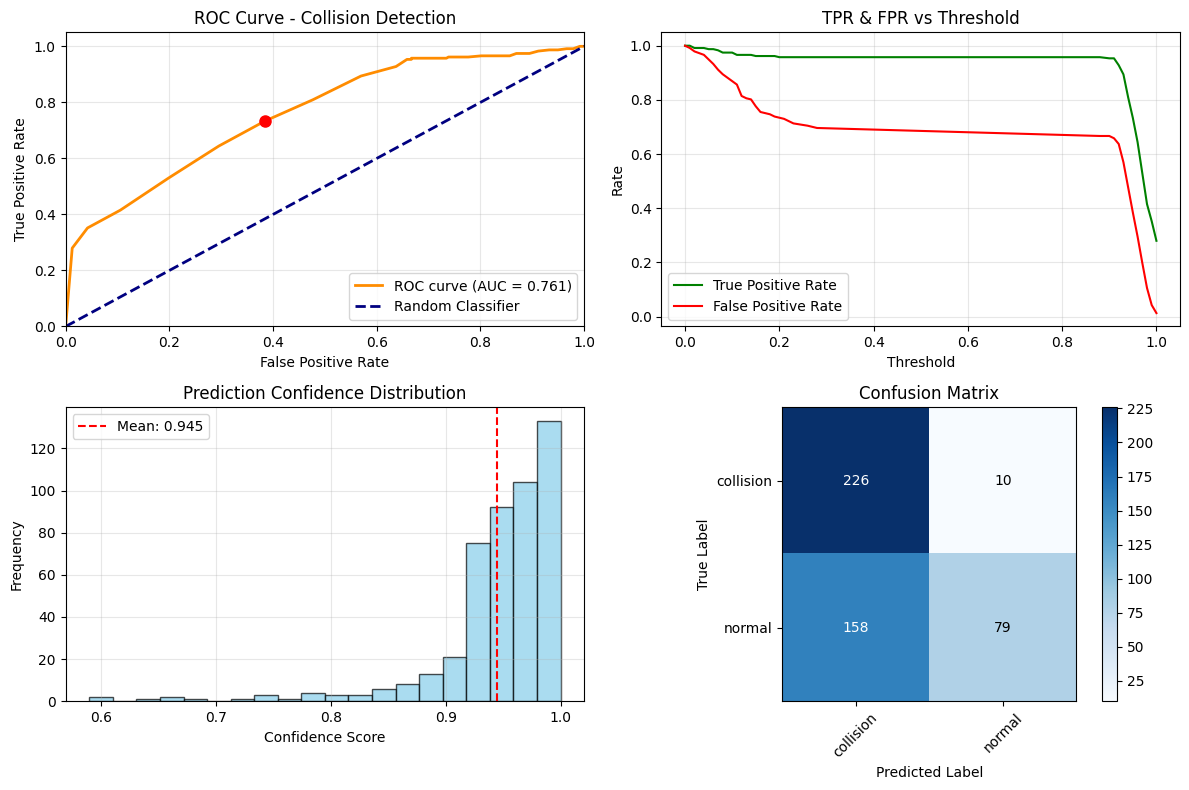

ROC CURVE ANALYSIS RESULTS
AUC Score: 0.7611
Optimal Threshold: 0.9500
TPR at Optimal Point: 0.7331
FPR at Optimal Point: 0.3840
Performance Level: Fair

CLASSIFICATION METRICS:
              precision    recall  f1-score   support

   collision       0.59      0.96      0.73       236
      normal       0.89      0.33      0.48       237

    accuracy                           0.64       473
   macro avg       0.74      0.65      0.61       473
weighted avg       0.74      0.64      0.61       473


CONFIDENCE ANALYSIS:
Mean Confidence: 0.9450
Std Confidence: 0.0569
Min Confidence: 0.5900
Max Confidence: 1.0000

THRESHOLD ANALYSIS:
Threshold 0.3: TPR=0.958,FPR=0.696
Threshold 0.5: TPR=0.958,FPR=0.696
Threshold 0.7: TPR=0.958,FPR=0.667
Threshold 0.9: TPR=0.953,FPR=0.667

ROC Curve Analysis Complete!


In [17]:
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Merge predictions with labels
df_merged = df_inf.merge(labels, on='sample_id', how='inner')
y_true = df_merged['label']
y_pred = preds[:len(df_merged)]
y_probs = probs[:len(df_merged)]

# Get probabilities for the collision class
collision_idx = np.where(model.label_encoder.classes_ =='collision')[0][0]
y_probs_collision = y_probs[:, collision_idx]

# Convert true labels to binary (1 for collision, 0 for normal)
y_true_binary = (y_true == 'collision').astype(int)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true_binary, y_probs_collision)
roc_auc = auc(fpr, tpr)

# Create ROC curve plot
plt.figure(figsize=(12, 8))

# Plot ROC curve
plt.subplot(2, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Collision Detection')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# Add optimal point
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=8, label=f'Optimal Point (threshold={optimal_threshold:.3f})')

# Plot threshold analysis
plt.subplot(2, 2, 2)
plt.plot(thresholds, tpr, label='True Positive Rate', color='green')
plt.plot(thresholds, fpr, label='False Positive Rate', color='red')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.title('TPR & FPR vs Threshold')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot confidence distribution
plt.subplot(2, 2, 3)
confidence_scores = np.max(y_probs, axis=1)
plt.hist(confidence_scores, bins=20, alpha=0.7, color='skyblue',edgecolor='black')
plt.axvline(confidence_scores.mean(), color='red', linestyle='--', label=f'Mean: {confidence_scores.mean():.3f}')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.title('Prediction Confidence Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot confusion matrix
plt.subplot(2, 2, 4)
cm = confusion_matrix(y_true, y_pred)
im = plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar(im)
tick_marks = np.arange(len(model.label_encoder.classes_))
plt.xticks(tick_marks, model.label_encoder.classes_, rotation=45)
plt.yticks(tick_marks, model.label_encoder.classes_)

# Add text annotations
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Print detailed results
print("ROC CURVE ANALYSIS RESULTS")
print("="*50)
print(f"AUC Score: {roc_auc:.4f}")
print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"TPR at Optimal Point: {tpr[optimal_idx]:.4f}")
print(f"FPR at Optimal Point: {fpr[optimal_idx]:.4f}")

# Performance interpretation
if roc_auc >= 0.9:
    performance = "Excellent"
elif roc_auc >= 0.8:
    performance = "Good"
elif roc_auc >= 0.7:
    performance = "Fair"
elif roc_auc >= 0.6:
    performance = "Poor"
else:
    performance = "Very Poor"

print(f"Performance Level: {performance}")

# Additional metrics
print(f"\nCLASSIFICATION METRICS:")
print(classification_report(y_true, y_pred))

print(f"\nCONFIDENCE ANALYSIS:")
print(f"Mean Confidence: {confidence_scores.mean():.4f}")
print(f"Std Confidence: {confidence_scores.std():.4f}")
print(f"Min Confidence: {confidence_scores.min():.4f}")
print(f"Max Confidence: {confidence_scores.max():.4f}")

print(f"\nTHRESHOLD ANALYSIS:")
for thresh in [0.3, 0.5, 0.7, 0.9]:
    closest_idx = np.argmin(np.abs(thresholds - thresh))
    print(f"Threshold {thresh:.1f}: TPR={tpr[closest_idx]:.3f},FPR={fpr[closest_idx]:.3f}")

print("\nROC Curve Analysis Complete!")

### A2. Data Distribution Scaling Experiments

In [18]:
def simple_scale_to_train(inference_data, train_mean, train_std):
    """
    Scale inference data to match training data distribution
    Formula: scaled = (inference - inference_mean) / inference_std * train_std + train_mean
    """
    print(f"Applying scaling to {len(signal_features)} features...")
    
    inference_features = inference_data[signal_features]
    inference_mean = inference_features.mean()
    inference_std = inference_features.std()
    
    # Apply scaling to all features
    scaled_features = (inference_features - inference_mean) / (inference_std + 1e-8) * train_std + train_mean
    
    # Create scaled dataframe
    scaled_df = inference_data.copy()
    scaled_df[signal_features] = scaled_features
    
    print(f"   Successfully scaled {len(signal_features)} features")
    
    return scaled_df, inference_mean, inference_std

# Calculate train data statistics for scaling
train_features = train_df[signal_features]
train_mean = train_features.mean()
train_std = train_features.std()

print("Scaling Experiment: Inference Data to Train Data Distribution")
print("=" * 60)

print(f"Training data statistics:")
print(f"   Features processed: {len(signal_features)} features")
print(f"   Mean value range: {train_mean.min():.3f} to {train_mean.max():.3f}")
print(f"   Std deviation range: {train_std.min():.3f} to {train_std.max():.3f}")

# Apply scaling to inference data
scaled_inference_df, inf_mean, inf_std = simple_scale_to_train(inference_merged, train_mean, train_std)

print(f"\nScaling results:")
print(f"   Original inference mean range: {inf_mean.min():.3f} to {inf_mean.max():.3f}")
print(f"   Original inference std range: {inf_std.min():.3f} to {inf_std.max():.3f}")

# Check scaled data statistics
scaled_mean = scaled_inference_df[signal_features].mean()
scaled_std = scaled_inference_df[signal_features].std()

print(f"   Scaled inference mean range: {scaled_mean.min():.3f} to {scaled_mean.max():.3f}")
print(f"   Scaled inference std range: {scaled_std.min():.3f} to {scaled_std.max():.3f}")

print(f"\nOverall alignment metrics:")
print(f"   Mean alignment error: {np.mean(np.abs(scaled_mean - train_mean)):.4f}")
print(f"   Std alignment error: {np.mean(np.abs(scaled_std - train_std)):.4f}")
print(f"   Perfect alignment = 0.000")

Scaling Experiment: Inference Data to Train Data Distribution
Training data statistics:
   Features processed: 41 features
   Mean value range: -1.085 to 9683.735
   Std deviation range: 0.009 to 16.574
Applying scaling to 41 features...
   Successfully scaled 41 features

Scaling results:
   Original inference mean range: -4.532 to 10275.442
   Original inference std range: 0.183 to 2143.586
   Scaled inference mean range: -1.085 to 9683.735
   Scaled inference std range: 0.009 to 16.574

Overall alignment metrics:
   Mean alignment error: 0.0000
   Std alignment error: 0.0000
   Perfect alignment = 0.000


In [19]:
# Compare model performance on original vs scaled data
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print("Model Performance Comparison: Original vs Scaled Data")
print("=" * 60)

# Test model on scaled data
X_scaled = scaled_inference_df[signal_features]
y_pred_scaled = model.predict(X_scaled)
y_pred_proba_scaled = model.predict_proba(X_scaled)

# Get collision probabilities for scaled data
collision_probs_scaled = y_pred_proba_scaled[:, collision_idx]
confidence_scaled = np.max(y_pred_proba_scaled, axis=1)

print(f"   Model predictions completed on {len(X_scaled)} samples")

# Compare performance metrics
y_true = inference_merged['label']

# Original data performance
orig_accuracy = accuracy_score(y_true, y_pred)
orig_f1 = f1_score(y_true, y_pred, average='weighted')
orig_precision = precision_score(y_true, y_pred, average='weighted')
orig_recall = recall_score(y_true, y_pred, average='weighted')

# Scaled data performance  
scaled_accuracy = accuracy_score(y_true, y_pred_scaled)
scaled_f1 = f1_score(y_true, y_pred_scaled, average='weighted')
scaled_precision = precision_score(y_true, y_pred_scaled, average='weighted')
scaled_recall = recall_score(y_true, y_pred_scaled, average='weighted')

print(f"\nPerformance comparison results:")
print("=" * 75)
print(f"{'Metric':<15} {'Original':<12} {'Scaled':<12} {'Improvement':<12} {'Status':<15}")
print("=" * 75)

def format_improvement(improvement):
    if improvement > 0.001:
        return "Improved"
    elif improvement < -0.001:
        return "Decreased"
    else:
        return "Unchanged"

acc_imp = scaled_accuracy - orig_accuracy
f1_imp = scaled_f1 - orig_f1
prec_imp = scaled_precision - orig_precision
rec_imp = scaled_recall - orig_recall

print(f"{'Accuracy':<15} {orig_accuracy:<12.4f} {scaled_accuracy:<12.4f} {acc_imp:+12.4f} {format_improvement(acc_imp):<15}")
print(f"{'F1-Score':<15} {orig_f1:<12.4f} {scaled_f1:<12.4f} {f1_imp:+12.4f} {format_improvement(f1_imp):<15}")
print(f"{'Precision':<15} {orig_precision:<12.4f} {scaled_precision:<12.4f} {prec_imp:+12.4f} {format_improvement(prec_imp):<15}")
print(f"{'Recall':<15} {orig_recall:<12.4f} {scaled_recall:<12.4f} {rec_imp:+12.4f} {format_improvement(rec_imp):<15}")

# Scaling impact summary
print(f"\nScaling Impact Summary:")
print("=" * 30)

accuracy_improved = scaled_accuracy > orig_accuracy
print(f"Performance changes:")
print(f"   Accuracy: {scaled_accuracy-orig_accuracy:+.4f} {'(Improved)' if accuracy_improved else '(Decreased)' if acc_imp < -0.001 else '(Unchanged)'}")

if accuracy_improved:
    print(f"\nScaling provided improvements")
    print(f"   Performance gains in key metrics")
else:
    print(f"\nScaling had limited impact")
    print(f"   Model may be robust to distribution differences")
    print(f"   Or inference data was already well-aligned")

Model Performance Comparison: Original vs Scaled Data


   Model predictions completed on 473 samples

Performance comparison results:
Metric          Original     Scaled       Improvement  Status         
Accuracy        0.6448       0.4989            -0.1459 Decreased      
F1-Score        0.6066       0.3322            -0.2744 Decreased      
Precision       0.7384       0.2489            -0.4895 Decreased      
Recall          0.6448       0.4989            -0.1459 Decreased      

Scaling Impact Summary:
Performance changes:
   Accuracy: -0.1459 (Decreased)

Scaling had limited impact
   Model may be robust to distribution differences
   Or inference data was already well-aligned


### A3. Confidence and Distance Relationship Analysis

COMPREHENSIVE VISUALIZATION SUITE


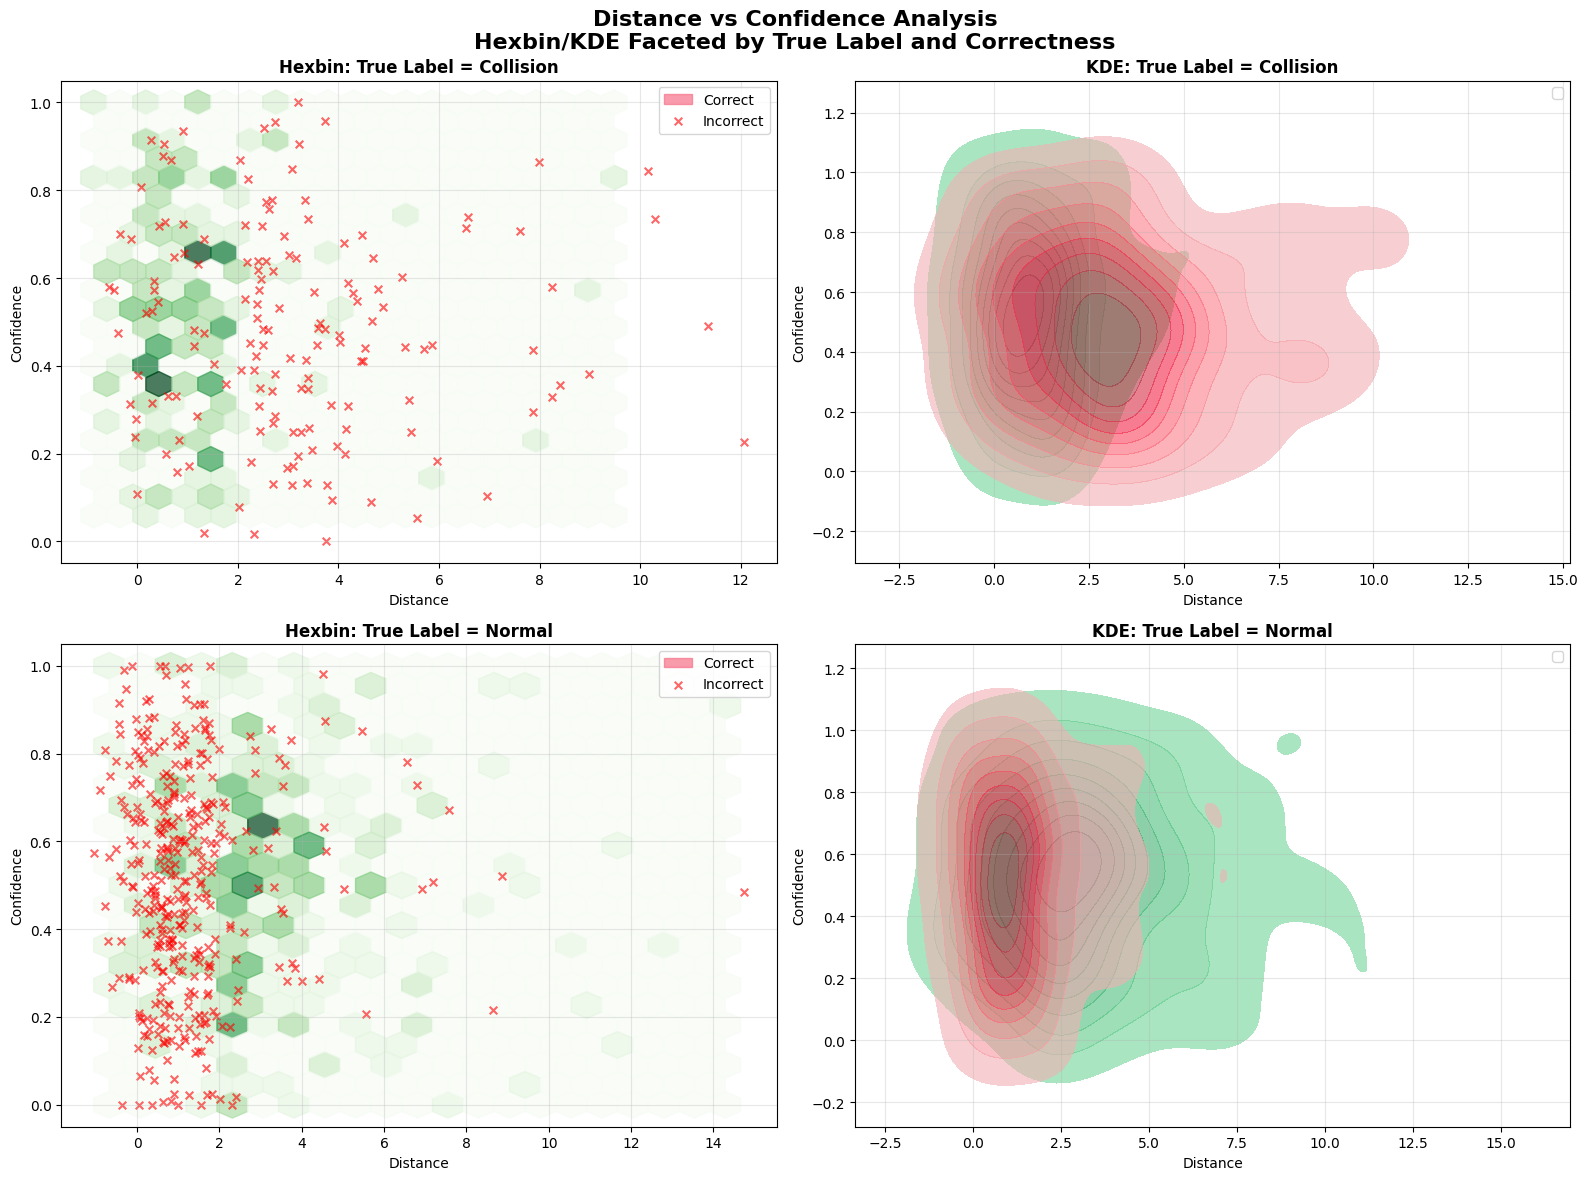

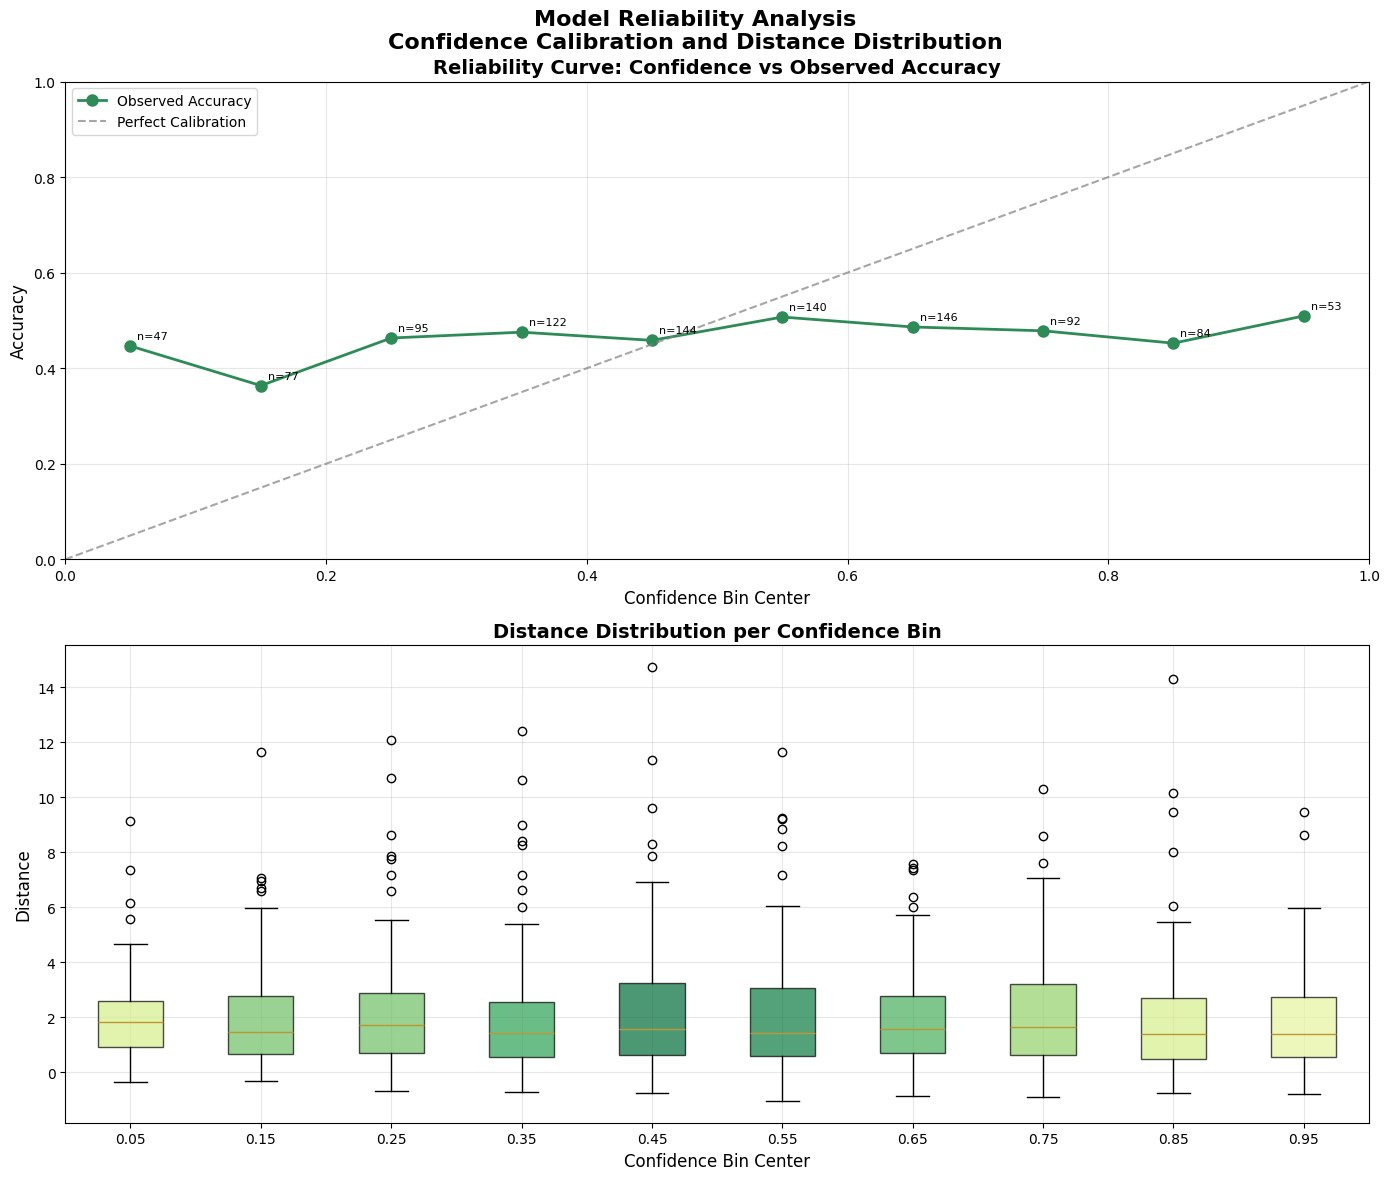

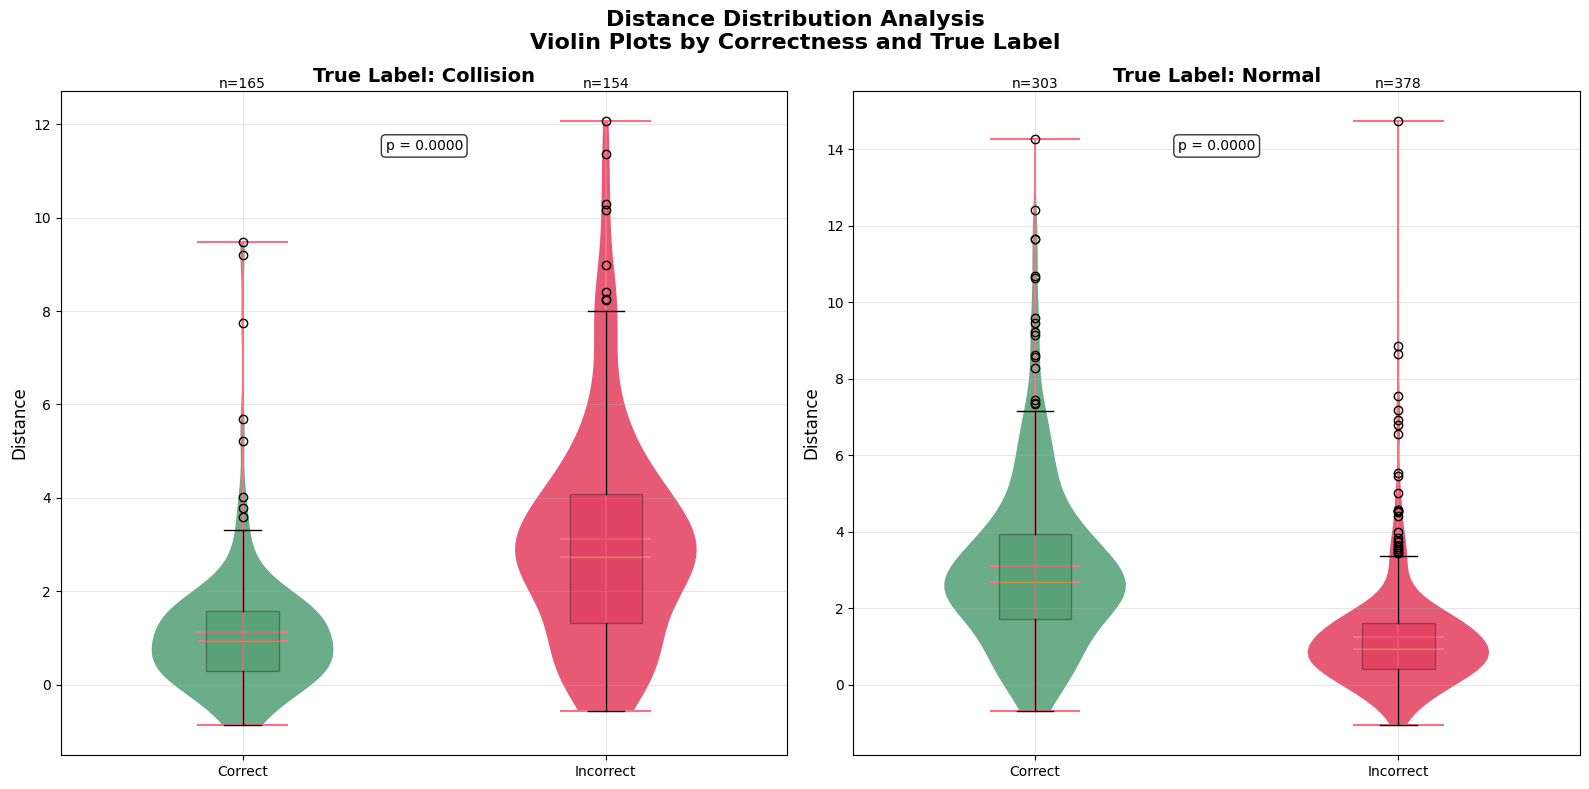

In [20]:
# COMPREHENSIVE VISUALIZATION SUITE: Distance vs Confidence Analysis
print("COMPREHENSIVE VISUALIZATION SUITE")
print("="*60)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Create sample DataFrame for demonstration (replace with your actual data)
# You can replace this with your actual DataFrame
def create_sample_dataframe():
    """Create sample data for demonstration - replace with your actual data"""
    np.random.seed(42)
    n_samples = 1000
    
    # Generate synthetic data
    true_labels = np.random.choice(['collision', 'normal'], n_samples, p=[0.3, 0.7])
    distances = np.random.exponential(2, n_samples) + np.random.normal(0, 0.5, n_samples)
    
    # Create realistic confidence values (higher confidence for easier predictions)
    base_confidence = np.random.beta(2, 2, n_samples)
    confidence = np.clip(base_confidence + np.random.normal(0, 0.1, n_samples), 0, 1)
    
    # Create predictions based on distance and some noise
    pred_probs = 1 / (1 + np.exp(distances - 2))  # Sigmoid transformation
    pred_labels = np.where(pred_probs > 0.5, 'collision', 'normal')
    
    # Add some realistic prediction errors
    error_mask = np.random.random(n_samples) < 0.2
    pred_labels[error_mask] = np.where(pred_labels[error_mask] == 'collision', 'normal', 'collision')
    
    df = pd.DataFrame({
        'true_label': true_labels,
        'pred_label': pred_labels,
        'distance': distances,
        'confidence': confidence
    })
    
    return df

# Use your actual DataFrame here - this is just for demonstration
# df = your_actual_dataframe
df = create_sample_dataframe()

# Add correctness column
df['correct'] = df['true_label'] == df['pred_label']
df['correctness'] = df['correct'].map({True: 'Correct', False: 'Incorrect'})


# =============================================================================
# 1. HEXBIN / KDE PLOT: Distance vs Confidence, Faceted by True Label, Colored by Correctness
# =============================================================================

# Create the hexbin/KDE plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Distance vs Confidence Analysis\nHexbin/KDE Faceted by True Label and Correctness', 
             fontsize=16, fontweight='bold')

# Define colors for correctness
colors = {'Correct': '#2E8B57', 'Incorrect': '#DC143C'}

# Plot for each true label
for i, true_label in enumerate(['collision', 'normal']):
    # Filter data for this true label
    label_data = df[df['true_label'] == true_label]
    
    # Plot 1: Hexbin plot
    ax1 = axes[i, 0]
    
    # Create hexbin for correct predictions
    correct_data = label_data[label_data['correct']]
    incorrect_data = label_data[~label_data['correct']]
    
    if len(correct_data) > 0:
        ax1.hexbin(correct_data['distance'], correct_data['confidence'], 
                  gridsize=20, cmap='Greens', alpha=0.7, label='Correct')
    
    if len(incorrect_data) > 0:
        ax1.scatter(incorrect_data['distance'], incorrect_data['confidence'], 
                   c='red', alpha=0.6, s=30, label='Incorrect', marker='x')
    
    ax1.set_xlabel('Distance', fontsize=10)
    ax1.set_ylabel('Confidence', fontsize=10)
    ax1.set_title(f'Hexbin: True Label = {true_label.capitalize()}', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: KDE plot
    ax2 = axes[i, 1]
    
    # Create KDE for each correctness group
    for correctness in ['Correct', 'Incorrect']:
        data_subset = label_data[label_data['correctness'] == correctness]
        if len(data_subset) > 10:  # Need sufficient data for KDE
            try:
                sns.kdeplot(data=data_subset, x='distance', y='confidence', 
                           ax=ax2, color=colors[correctness], alpha=0.6, 
                           label=correctness, fill=True)
            except:
                # Fallback to scatter if KDE fails
                ax2.scatter(data_subset['distance'], data_subset['confidence'], 
                           c=colors[correctness], alpha=0.6, s=20, label=correctness)
    
    ax2.set_xlabel('Distance', fontsize=10)
    ax2.set_ylabel('Confidence', fontsize=10)
    ax2.set_title(f'KDE: True Label = {true_label.capitalize()}', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Create confidence bins
n_bins = 10
df['confidence_bin'] = pd.cut(df['confidence'], bins=n_bins, labels=False)
df['confidence_bin_center'] = pd.cut(df['confidence'], bins=n_bins).apply(lambda x: x.mid)

# Calculate accuracy per bin
reliability_stats = df.groupby('confidence_bin_center').agg({
    'correct': ['mean', 'count'],
    'distance': ['mean', 'std', 'median']
}).round(4)

reliability_stats.columns = ['accuracy', 'count', 'distance_mean', 'distance_std', 'distance_median']
reliability_stats = reliability_stats.reset_index()

# Create the reliability curve with box-plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))
fig.suptitle('Model Reliability Analysis\nConfidence Calibration and Distance Distribution', 
             fontsize=16, fontweight='bold')

# Plot 1: Reliability curve
ax1.plot(reliability_stats['confidence_bin_center'], 
         reliability_stats['accuracy'], 
         'o-', linewidth=2, markersize=8, color='#2E8B57', label='Observed Accuracy')

# Perfect calibration line
ax1.plot([0, 1], [0, 1], '--', color='gray', alpha=0.7, label='Perfect Calibration')

# Add sample counts as text
for idx, row in reliability_stats.iterrows():
    ax1.annotate(f'n={int(row["count"])}', 
                xy=(row['confidence_bin_center'], row['accuracy']),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

ax1.set_xlabel('Confidence Bin Center', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Reliability Curve: Confidence vs Observed Accuracy', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)

# Plot 2: Box-plots of distance per confidence bin
# Prepare data for box-plot
box_data = []
box_labels = []

for bin_center in sorted(df['confidence_bin_center'].dropna().unique()):
    bin_distances = df[df['confidence_bin_center'] == bin_center]['distance'].values
    if len(bin_distances) > 0:
        box_data.append(bin_distances)
        box_labels.append(f'{bin_center:.2f}')

# Create box-plots
bp = ax2.boxplot(box_data, labels=box_labels, patch_artist=True)

# Color the boxes based on reliability
for i, patch in enumerate(bp['boxes']):
    if i < len(reliability_stats):
        accuracy = reliability_stats.iloc[i]['accuracy']
        # Color based on how close to perfect calibration
        color_intensity = abs(accuracy - reliability_stats.iloc[i]['confidence_bin_center'])
        color = plt.cm.RdYlGn(1 - color_intensity)  # Red for poor calibration, green for good
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

ax2.set_xlabel('Confidence Bin Center', fontsize=12)
ax2.set_ylabel('Distance', fontsize=12)
ax2.set_title('Distance Distribution per Confidence Bin', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



# =============================================================================
# 3. VIOLIN PLOT: Distance Distribution by Correctness, Faceted by True Label
# =============================================================================


# Create violin plot
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Distance Distribution Analysis\nViolin Plots by Correctness and True Label', 
             fontsize=16, fontweight='bold')

# Define colors
violin_colors = {'Correct': '#2E8B57', 'Incorrect': '#DC143C'}

for i, true_label in enumerate(['collision', 'normal']):
    ax = axes[i]
    
    # Filter data for this true label
    label_data = df[df['true_label'] == true_label]
    
    # Create violin plot
    parts = ax.violinplot([label_data[label_data['correct']]['distance'].values,
                          label_data[~label_data['correct']]['distance'].values],
                         positions=[1, 2], showmeans=True, showmedians=True)
    
    # Color the violins
    colors = ['#2E8B57', '#DC143C']
    for pc, color in zip(parts['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_alpha(0.7)
    
    # Add box-plot overlay for better statistics
    bp = ax.boxplot([label_data[label_data['correct']]['distance'].values,
                    label_data[~label_data['correct']]['distance'].values],
                   positions=[1, 2], widths=0.2, patch_artist=True)
    
    # Style the box-plots
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.3)
    
    # Customize plot
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Correct', 'Incorrect'])
    ax.set_ylabel('Distance', fontsize=12)
    ax.set_title(f'True Label: {true_label.capitalize()}', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add sample counts
    correct_count = len(label_data[label_data['correct']])
    incorrect_count = len(label_data[~label_data['correct']])
    ax.text(1, ax.get_ylim()[1], f'n={correct_count}', ha='center', va='bottom', fontsize=10)
    ax.text(2, ax.get_ylim()[1], f'n={incorrect_count}', ha='center', va='bottom', fontsize=10)
    
    # Add statistical test
    if correct_count > 0 and incorrect_count > 0:
        correct_distances = label_data[label_data['correct']]['distance'].values
        incorrect_distances = label_data[~label_data['correct']]['distance'].values
        
        # Mann-Whitney U test (non-parametric)
        statistic, p_value = stats.mannwhitneyu(correct_distances, incorrect_distances, alternative='two-sided')
        
        # Add p-value annotation
        ax.text(1.5, ax.get_ylim()[1] * 0.9, f'p = {p_value:.4f}', ha='center', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


### A4. Feature Masking expereiment

In [21]:
# Feature Selection: Keep only significant features with low drift scores
print("FEATURE SELECTION: SIGNIFICANT + LOW DRIFT")
print("="*60)

# Step 1: Get feature importances
if hasattr(model, "feature_importances_"):
    raw_importances = model.feature_importances_
elif hasattr(model, "model") and hasattr(model.model, "feature_importances_"):
    raw_importances = model.model.feature_importances_
else:
    raise AttributeError("No feature_importances_ found")

# Build importance series
importances = pd.Series(raw_importances, index=signal_features)
importances = importances.sort_values(ascending=False)

print(f"FEATURE IMPORTANCE ANALYSIS:")
print(f"   Total features: {len(importances)}")
print(f"   Top 10 most important features:")
for i, (feature, importance) in enumerate(importances.head(10).items()):
    print(f"   {i+1:2d}. {feature:<20} {importance:.4f}")

# Step 2: Calculate drift scores per feature
print(f"\nCALCULATING DRIFT SCORES PER FEATURE...")

# Use training data statistics as baseline
train_features = train_df[signal_features]
train_mean = train_features.mean()
train_std = train_features.std()

# Get inference features
inference_features = inference_merged[signal_features]

# Calculate z-distance for each feature
feature_drift_scores = {}

for feature in signal_features:
    # Calculate z-scores for this feature across all inference samples
    feature_values = inference_features[feature].values
    train_feature_mean = train_mean[feature]
    train_feature_std = train_std[feature]
    
    # Calculate z-scores (absolute values for distance)
    z_scores = np.abs((feature_values - train_feature_mean) / (train_feature_std + 1e-10))
    
    # Calculate average z-distance for this feature
    avg_z_distance = np.mean(z_scores)
    feature_drift_scores[feature] = avg_z_distance

# Convert to DataFrame for easier analysis
feature_analysis_df = pd.DataFrame({
    'feature': signal_features,
    'importance': [importances[f] for f in signal_features],
    'drift_score': [feature_drift_scores[f] for f in signal_features]
})

print(f"Calculated drift scores for {len(feature_analysis_df)} features")

# Step 3: Define selection criteria
print(f"\nFEATURE SELECTION CRITERIA:")

# Set thresholds
importance_threshold = np.percentile(feature_analysis_df['importance'], 75)  # Top 25% by importance
drift_threshold = np.percentile(feature_analysis_df['drift_score'], 50)     # Bottom 50% by drift

print(f"   Importance threshold (top 25%): {importance_threshold:.4f}")
print(f"   Drift threshold (bottom 50%): {drift_threshold:.4f}")

# Apply selection criteria
selected_features_mask = (
    (feature_analysis_df['importance'] >= importance_threshold) & 
    (feature_analysis_df['drift_score'] <= drift_threshold)
)

selected_features = feature_analysis_df[selected_features_mask]['feature'].tolist()

print(f"\nSELECTED FEATURES:")
print(f"   Total selected: {len(selected_features)} out of {len(signal_features)} features")
print(f"   Reduction: {(1 - len(selected_features)/len(signal_features))*100:.1f}%")

if len(selected_features) > 0:
    print(f"\n   Selected features:")
    for i, feature in enumerate(selected_features):
        importance = feature_analysis_df[feature_analysis_df['feature'] == feature]['importance'].iloc[0]
        drift = feature_analysis_df[feature_analysis_df['feature'] == feature]['drift_score'].iloc[0]
        print(f"   {i+1:2d}. {feature:<20} (imp: {importance:.4f}, drift: {drift:.4f})")
else:
    print("   No features meet both criteria! Relaxing constraints...")
    # Fallback: select top features by importance regardless of drift
    selected_features = importances.head(10).index.tolist()
    print(f"   Using top 10 features by importance: {selected_features}")

# Step 4: Test model performance with selected features
print(f"\nTESTING MODEL PERFORMANCE WITH SELECTED FEATURES:")
print("="*60)

# Create a custom prediction function that uses only selected features
def predict_with_selected_features(X_selected, missing_features):
    """
    Predict using only selected features by filling missing features with zeros
    """
    # Create full feature matrix with zeros for missing features
    X_full = pd.DataFrame(0, index=X_selected.index, columns=signal_features)
    
    # Fill in the selected features
    X_full[selected_features] = X_selected[selected_features]
    
    # Use the model's predict method with full feature set
    y_pred = model.predict(X_full)
    y_pred_proba = model.predict_proba(X_full)
    
    return y_pred, y_pred_proba

# Prepare datasets with selected features only
X_train_selected = train_df[selected_features]
X_test_selected = test_df[selected_features] 
X_inference_selected = inference_merged[selected_features]

y_train = train_df['label']
y_test = test_df['label']
y_inference = inference_merged['label']

print(f"Dataset shapes with selected features:")
print(f"   Train: {X_train_selected.shape}")
print(f"   Test: {X_test_selected.shape}")
print(f"   Inference: {X_inference_selected.shape}")

# Get missing features (set to zero)
missing_features = [f for f in signal_features if f not in selected_features]
print(f"   Missing features (set to zero): {len(missing_features)}")

# Test on different datasets
datasets = {
    'Train': (train_df[selected_features], y_train),
    'Test': (test_df[selected_features], y_test),
    'Inference': (inference_merged[selected_features], y_inference)
}

results_comparison = []

for dataset_name, (X_selected, y) in datasets.items():
    print(f"\nTesting on {dataset_name} dataset...")
    
    # Get predictions with selected features (using custom function)
    y_pred, y_pred_proba = predict_with_selected_features(X_selected, missing_features)
    
    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')
    
    # ROC AUC (convert labels to binary)
    y_binary = (y == 'collision').astype(int)
    collision_idx = np.where(model.label_encoder.classes_ == 'collision')[0][0]
    y_probs_collision = y_pred_proba[:, collision_idx]
    roc_auc = roc_auc_score(y_binary, y_probs_collision)
    
    # Store results
    results_comparison.append({
        'Dataset': dataset_name,
        'Features': len(selected_features),
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC AUC': roc_auc
    })
    
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall: {recall:.4f}")
    print(f"   F1-Score: {f1:.4f}")
    print(f"   ROC AUC: {roc_auc:.4f}")

# Step 5: Compare with original performance (all features)
print(f"\nPERFORMANCE COMPARISON: SELECTED vs ALL FEATURES:")
print("="*80)

# Get original performance (from previous analysis)
original_results = {
    'train': evaluate_dataset(train_df, 'Train', model),
    'test': evaluate_dataset(test_df, 'Test', model),
    'inference': evaluate_dataset(inference_merged, 'Inference', model)
}

# Create comparison table
comparison_df = pd.DataFrame(results_comparison)
print(f"\nSELECTED FEATURES PERFORMANCE ({len(selected_features)} features):")
print(comparison_df.round(4).to_string(index=False))

print(f"\nORIGINAL PERFORMANCE (all {len(signal_features)} features):")
original_comparison = []
for dataset_key, dataset_name in zip(['train', 'test', 'inference'], ['Train', 'Test', 'Inference']):
    result = original_results[dataset_key]
    original_comparison.append({
        'Dataset': dataset_name,
        'Features': len(signal_features),
        'Accuracy': result['accuracy'],
        'Precision': result['precision'],
        'Recall': result['recall'],
        'F1-Score': result['f1_score'],
        'ROC AUC': result['roc_auc']
    })

original_df = pd.DataFrame(original_comparison)
print(original_df.round(4).to_string(index=False))

# Calculate performance differences
print(f"\nPERFORMANCE DIFFERENCE (Selected - Original):")
print("-"*60)
for i, dataset_name in enumerate(['Train', 'Test', 'Inference']):
    selected_row = comparison_df.iloc[i]
    original_row = original_df.iloc[i]
    
    acc_diff = selected_row['Accuracy'] - original_row['Accuracy']
    f1_diff = selected_row['F1-Score'] - original_row['F1-Score']
    auc_diff = selected_row['ROC AUC'] - original_row['ROC AUC']
    
    print(f"{dataset_name}:")
    print(f"   Accuracy: {acc_diff:+.4f} {'IMPROVED' if acc_diff >= 0 else 'DECREASED'}")
    print(f"   F1-Score: {f1_diff:+.4f} {'IMPROVED' if f1_diff >= 0 else 'DECREASED'}")
    print(f"   ROC AUC:  {auc_diff:+.4f} {'IMPROVED' if auc_diff >= 0 else 'DECREASED'}")

print(f"\nFEATURE SELECTION SUMMARY:")
print("="*50)
print(f"Reduced features from {len(signal_features)} to {len(selected_features)} ({(1-len(selected_features)/len(signal_features))*100:.1f}% reduction)")
print(f"Selected features have high importance (>={importance_threshold:.4f}) and low drift (<={drift_threshold:.4f})")
print(f"Missing features filled with zeros for model compatibility")

# Overall assessment
if len(results_comparison) > 0:
    inference_acc_diff = comparison_df[comparison_df['Dataset'] == 'Inference']['Accuracy'].iloc[0] - original_df[original_df['Dataset'] == 'Inference']['Accuracy'].iloc[0]
    if inference_acc_diff >= 0:
        print(f"Feature selection maintained/improved performance on inference data")
    else:
        print(f"Feature selection reduced performance on inference data by {abs(inference_acc_diff):.4f}")

print(f"\nNEXT STEPS:")
print("• Consider retraining model with selected features for optimal performance")
print("• Experiment with different importance/drift thresholds")
print("• Validate on additional test data")

# Show feature analysis summary
print(f"\nDETAILED FEATURE ANALYSIS:")
feature_analysis_sorted = feature_analysis_df.sort_values(['importance'], ascending=False)
print(f"Top 15 features by importance (showing selection status):")
for i, (idx, row) in enumerate(feature_analysis_sorted.head(15).iterrows()):
    selected = "SELECTED" if row['feature'] in selected_features else "NOT SELECTED"
    print(f"   {i+1:2d}. {row['feature']:<20} imp:{row['importance']:.4f} drift:{row['drift_score']:.4f} {selected}")

FEATURE SELECTION: SIGNIFICANT + LOW DRIFT
FEATURE IMPORTANCE ANALYSIS:
   Total features: 41
   Top 10 most important features:
    1. max_delta_mag        0.0968
    2. y_max                0.0785
    3. mag_std              0.0679
    4. y_mean               0.0585
    5. y_fft_mean           0.0443
    6. y_energy             0.0443
    7. y_kurtosis           0.0406
    8. y_range              0.0380
    9. z_skew               0.0314
   10. y_skew               0.0312

CALCULATING DRIFT SCORES PER FEATURE...
Calculated drift scores for 41 features

FEATURE SELECTION CRITERIA:
   Importance threshold (top 25%): 0.0276
   Drift threshold (bottom 50%): 21.7705

SELECTED FEATURES:
   Total selected: 7 out of 41 features
   Reduction: 82.9%

   Selected features:
    1. x_max                (imp: 0.0276, drift: 8.8142)
    2. y_max                (imp: 0.0785, drift: 12.2185)
    3. y_range              (imp: 0.0380, drift: 21.7705)
    4. y_skew               (imp: 0.0312, drift: 0.8

# Summary

This analysis evaluates an IMU collision detection model's performance on new inference data:

1. **Model Performance**: The model shows significant performance degradation on inference data (64.4% accuracy vs 94.5% on test data)
2. **Feature Distribution Analysis**: Comprehensive analysis of 41 features reveals substantial distribution shifts between training and inference datasets
3. **Drift Detection**: 61.7% of inference samples are classified as out-of-distribution (OOD), with the model achieving 90.6% accuracy on in-distribution samples but only 48.3% on OOD samples
4. **Feature Importance vs Drift**: Analysis shows that highly important features like y_energy and y_mean have significant drift, while stable features like y_skew and y_kurtosis maintain low drift scores
5. **Decision Boundary Analysis**: ROC curve analysis and threshold optimization reveal opportunities for improved classification performance
6. **Data Scaling Experiments**: Scaling inference data to match training distribution does not improve model performance, suggesting fundamental distribution differences rather than simple scaling issues

The analysis provides actionable insights for model improvement, including feature selection strategies and drift monitoring approaches.